In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib.collections import LineCollection


from scipy import stats
from scipy.signal import find_peaks, hilbert, windows
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize

from collections import Counter
from itertools import product, chain
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

import glob
import os

from scipy.signal.windows import blackman

from datetime import datetime

from importlib import reload
import matplotlib
reload(matplotlib)
#from matplotlib import rc

#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

<module 'matplotlib' from '/home/denys/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py'>

A utility to get filenames time-date stamped

In [2]:
def get_unique_filename(fname):
    return fname.format(
        datetime.now().strftime("_%m-%d_%H-%M")
    )

# Loading and pre-processing pulses

In [3]:
folder_data = "03-11-2022"

os.listdir(folder_data)

['gradient', 'pulses', 'long_waveforms']

## Loading "pure" harmonics

In [4]:
pulses = {}

# declare type
@dataclass
class Pulse:
    time: np.ndarray
    field: np.ndarray
    _individual_fields: np.ndarray = None
    peaks_time: np.ndarray = None
    time_range: np.ndarray = None
    half_period: float = 0
    interp_field: InterpolatedUnivariateSpline = None
    err_lower_bound: InterpolatedUnivariateSpline = None
    err_upper_bound: InterpolatedUnivariateSpline = None
    
# save maximal amplitude of the field
max_ampl = []

for freq in range(5, 9):
    
    # load all pulses for the given frequency
    filenames = glob.glob(folder_data + '/pulses/N0_F0{}_*.dat'.format(freq))
    
    all_data = [np.loadtxt(_).T[:-1] for _ in filenames]
    
    times, _individual_fields = zip(*all_data)
    
    _individual_fields = np.array(_individual_fields)
    
    time = times[0]
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"

    #  Checking whether the time axis coincide
    assert all(np.allclose(time, _) for _ in times), \
        "This workbook cannot be used since the time data is not syncronized"
    
    label = '0.{} THz'.format(freq)
    print("{} files loaded for {}".format(len(filenames), label))

    
    field = np.mean(_individual_fields, axis=0)
    
    # Substract the mean from experimental fields to compensate for parasitic offset
    field -= field.mean()
    
    # calculate the confidence interval
    confidence_level = 0.95
    
    sigma = stats.sem(_individual_fields, axis=0)
    sigma = np.clip(sigma, 1e-20, sigma.max())
    
    err_lower_bound, err_upper_bound = stats.t.interval(
        confidence_level, 
        _individual_fields.shape[0], 
        field, 
        sigma,
    )
        
    abs_field = np.abs(field)

    max_ampl.append(abs_field.max())
    
    # Extract information for the combinatorial method     
    ampl_threshold = 0.4 * abs_field.max()
    
    indx = find_peaks(abs_field, height=ampl_threshold)[0]
    peaks_time = time[indx[1:-1]]
    
    half_period = Counter(np.diff(peaks_time)).most_common(1)[0][0]
        
    # Saving the data 
    pulses[label] = Pulse(
        time = time, 
        field = field,
        _individual_fields = _individual_fields,
        peaks_time = peaks_time,
        time_range = time[indx[1]:indx[-2]],
        half_period = half_period,
        # first save confidence interval as arrays
        err_lower_bound = err_lower_bound,
        err_upper_bound = err_upper_bound,
    )
    
# saving the largest frequency
largest_freq = label

#  Checking whether the time axis coincide
assert all(np.allclose(time, data.time) for data in pulses.values()), \
    "This workbook cannot be used since the time data is not syncronized"

# saving time step
dtime = time[1] - time[0]

max_ampl = max(max_ampl)

# Normalazing fields and interpolating
for data in pulses.values():
    data.field /= max_ampl
    
    data.interp_field = UnivariateSpline(
        data.time, 
        data.field,
        ext='zeros', 
        k=3, 
        s=0
    )

    # interpolate confidence interval
    data.err_lower_bound = UnivariateSpline(
        data.time, 
        data.err_lower_bound / max_ampl, 
        ext='zeros', 
        k=3, 
        s=0
    )
    
    data.err_upper_bound = UnivariateSpline(
        data.time, 
        data.err_upper_bound / max_ampl, 
        ext='zeros', 
        k=3, 
        s=0
    )

5 files loaded for 0.5 THz
5 files loaded for 0.6 THz
5 files loaded for 0.7 THz
5 files loaded for 0.8 THz


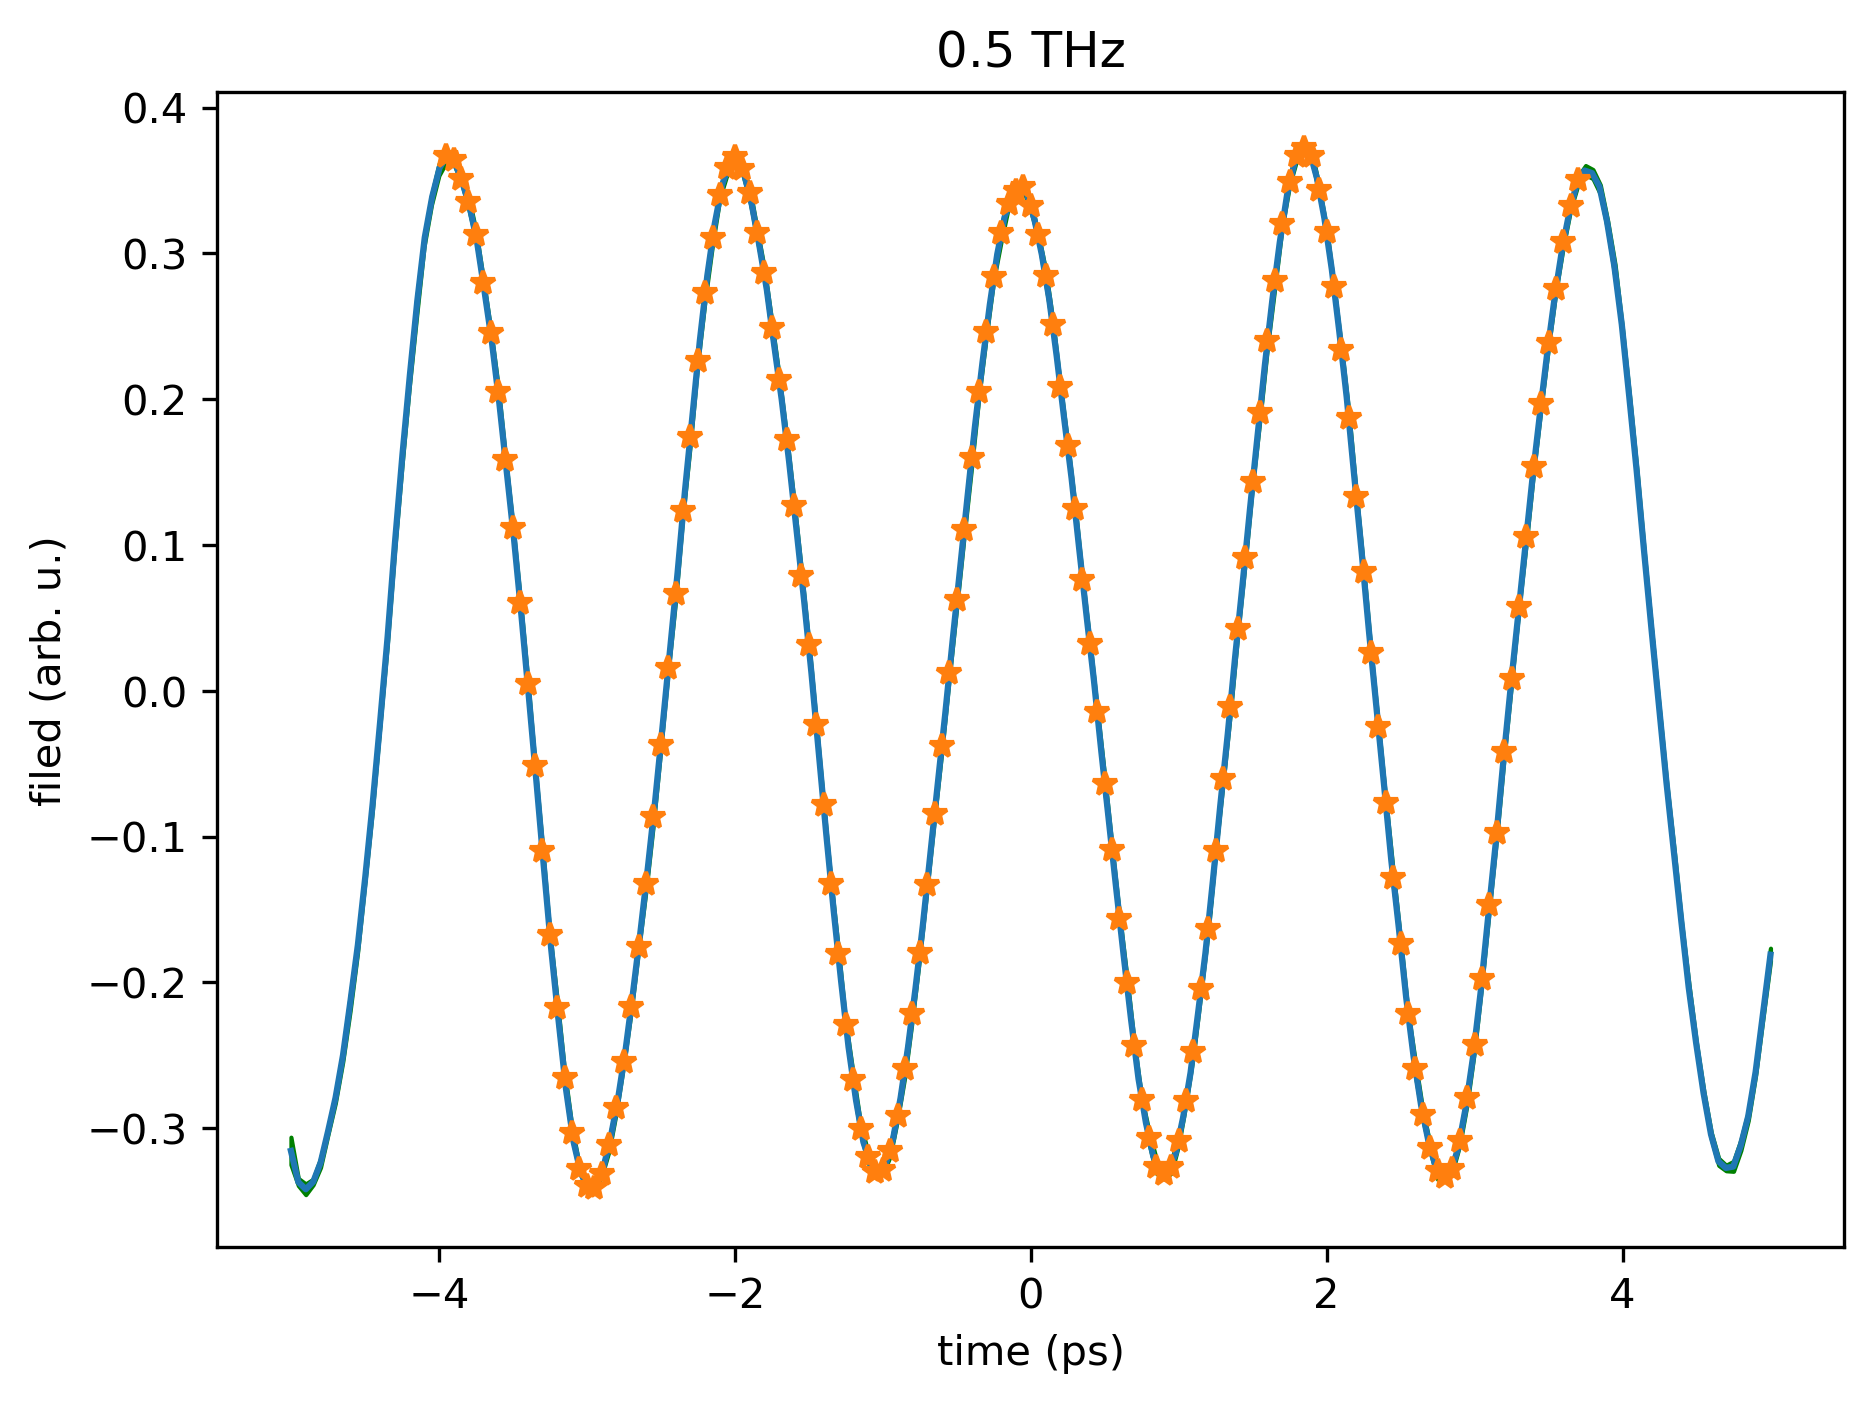

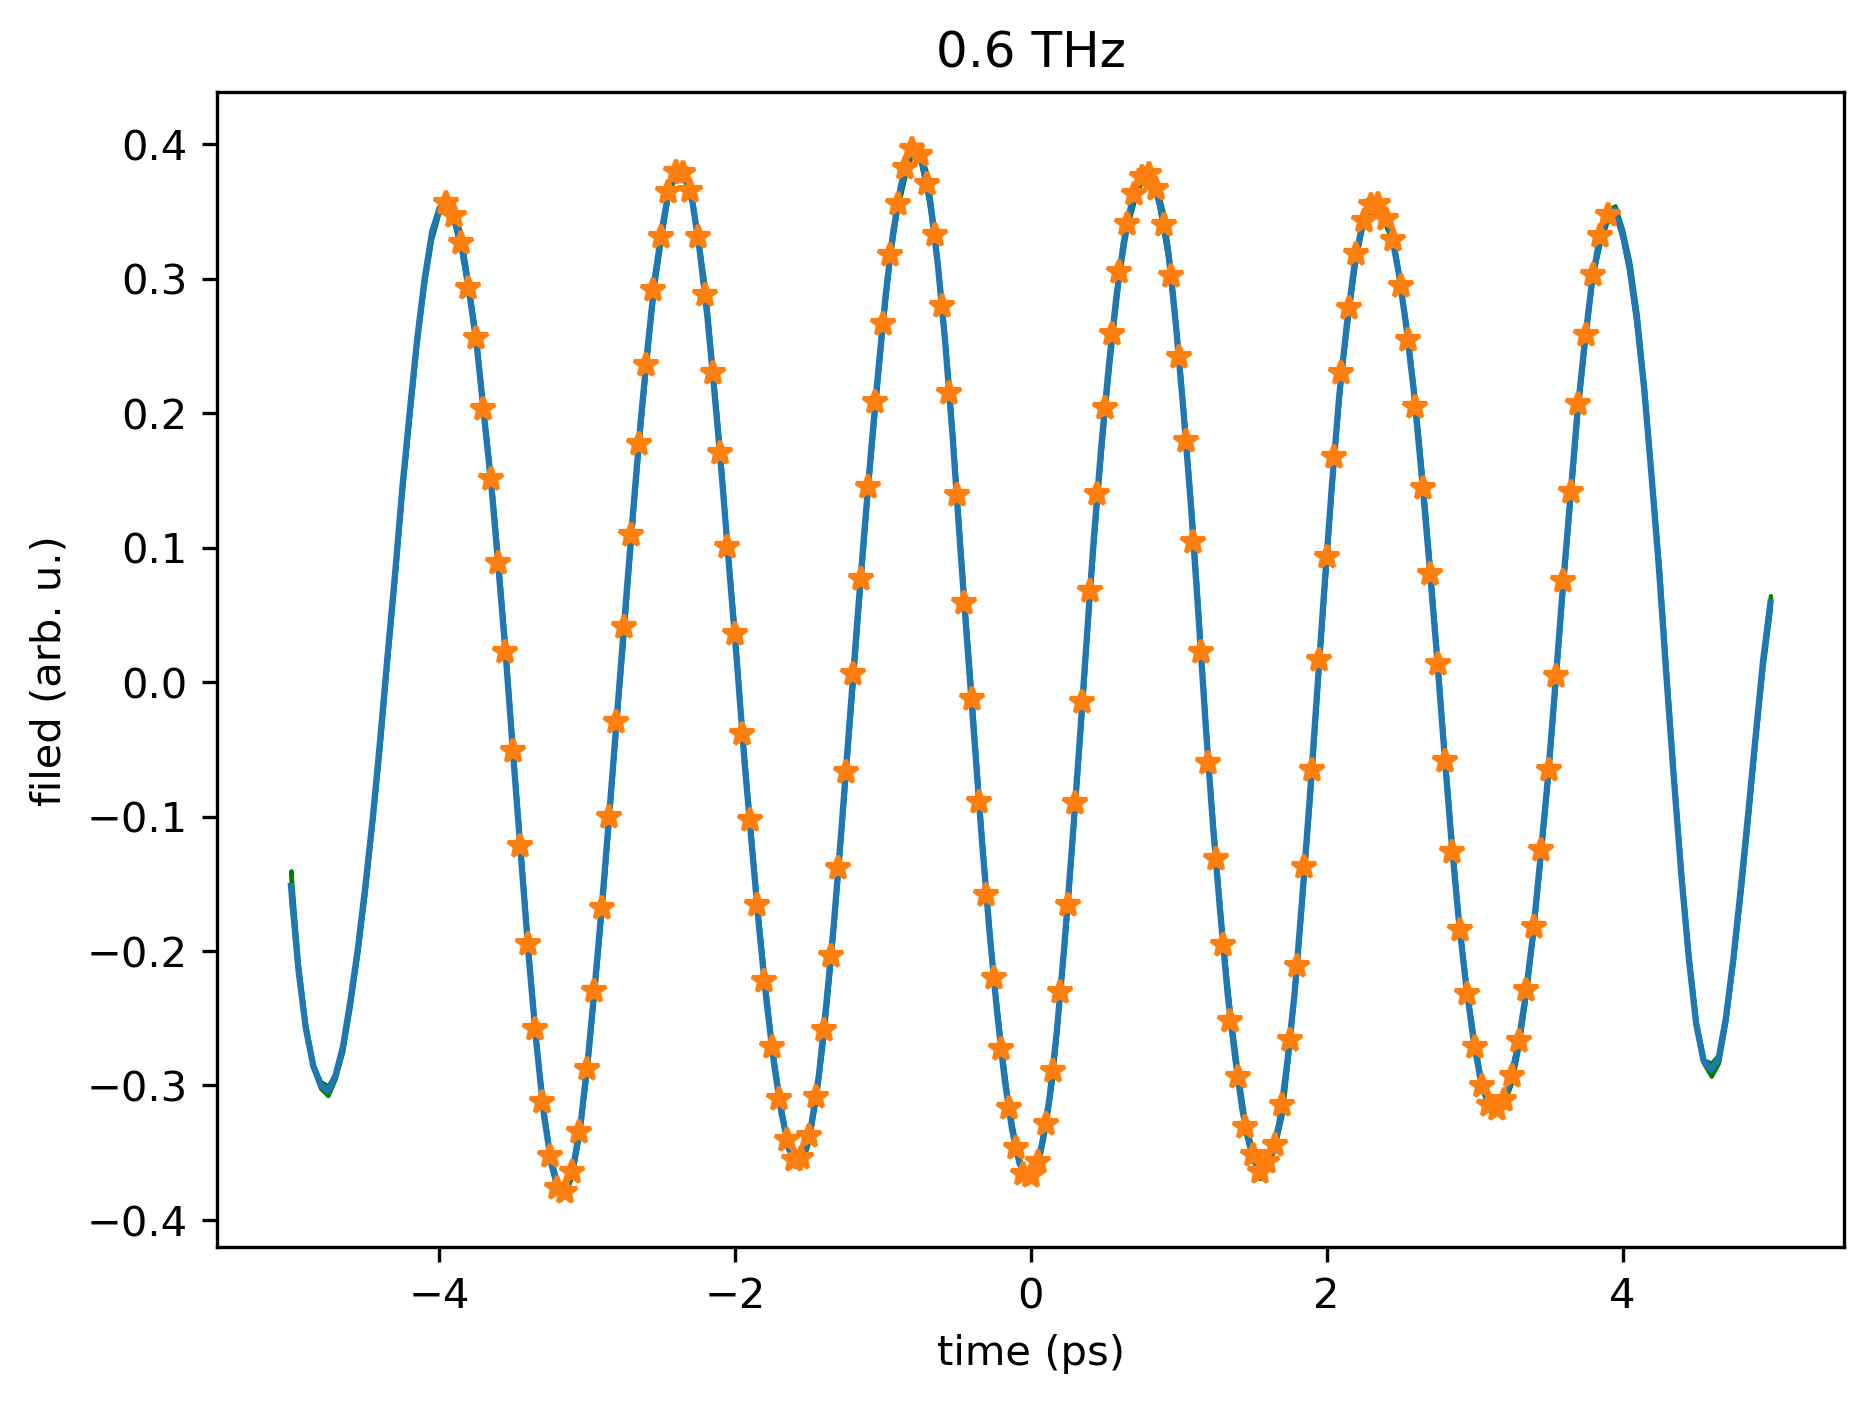

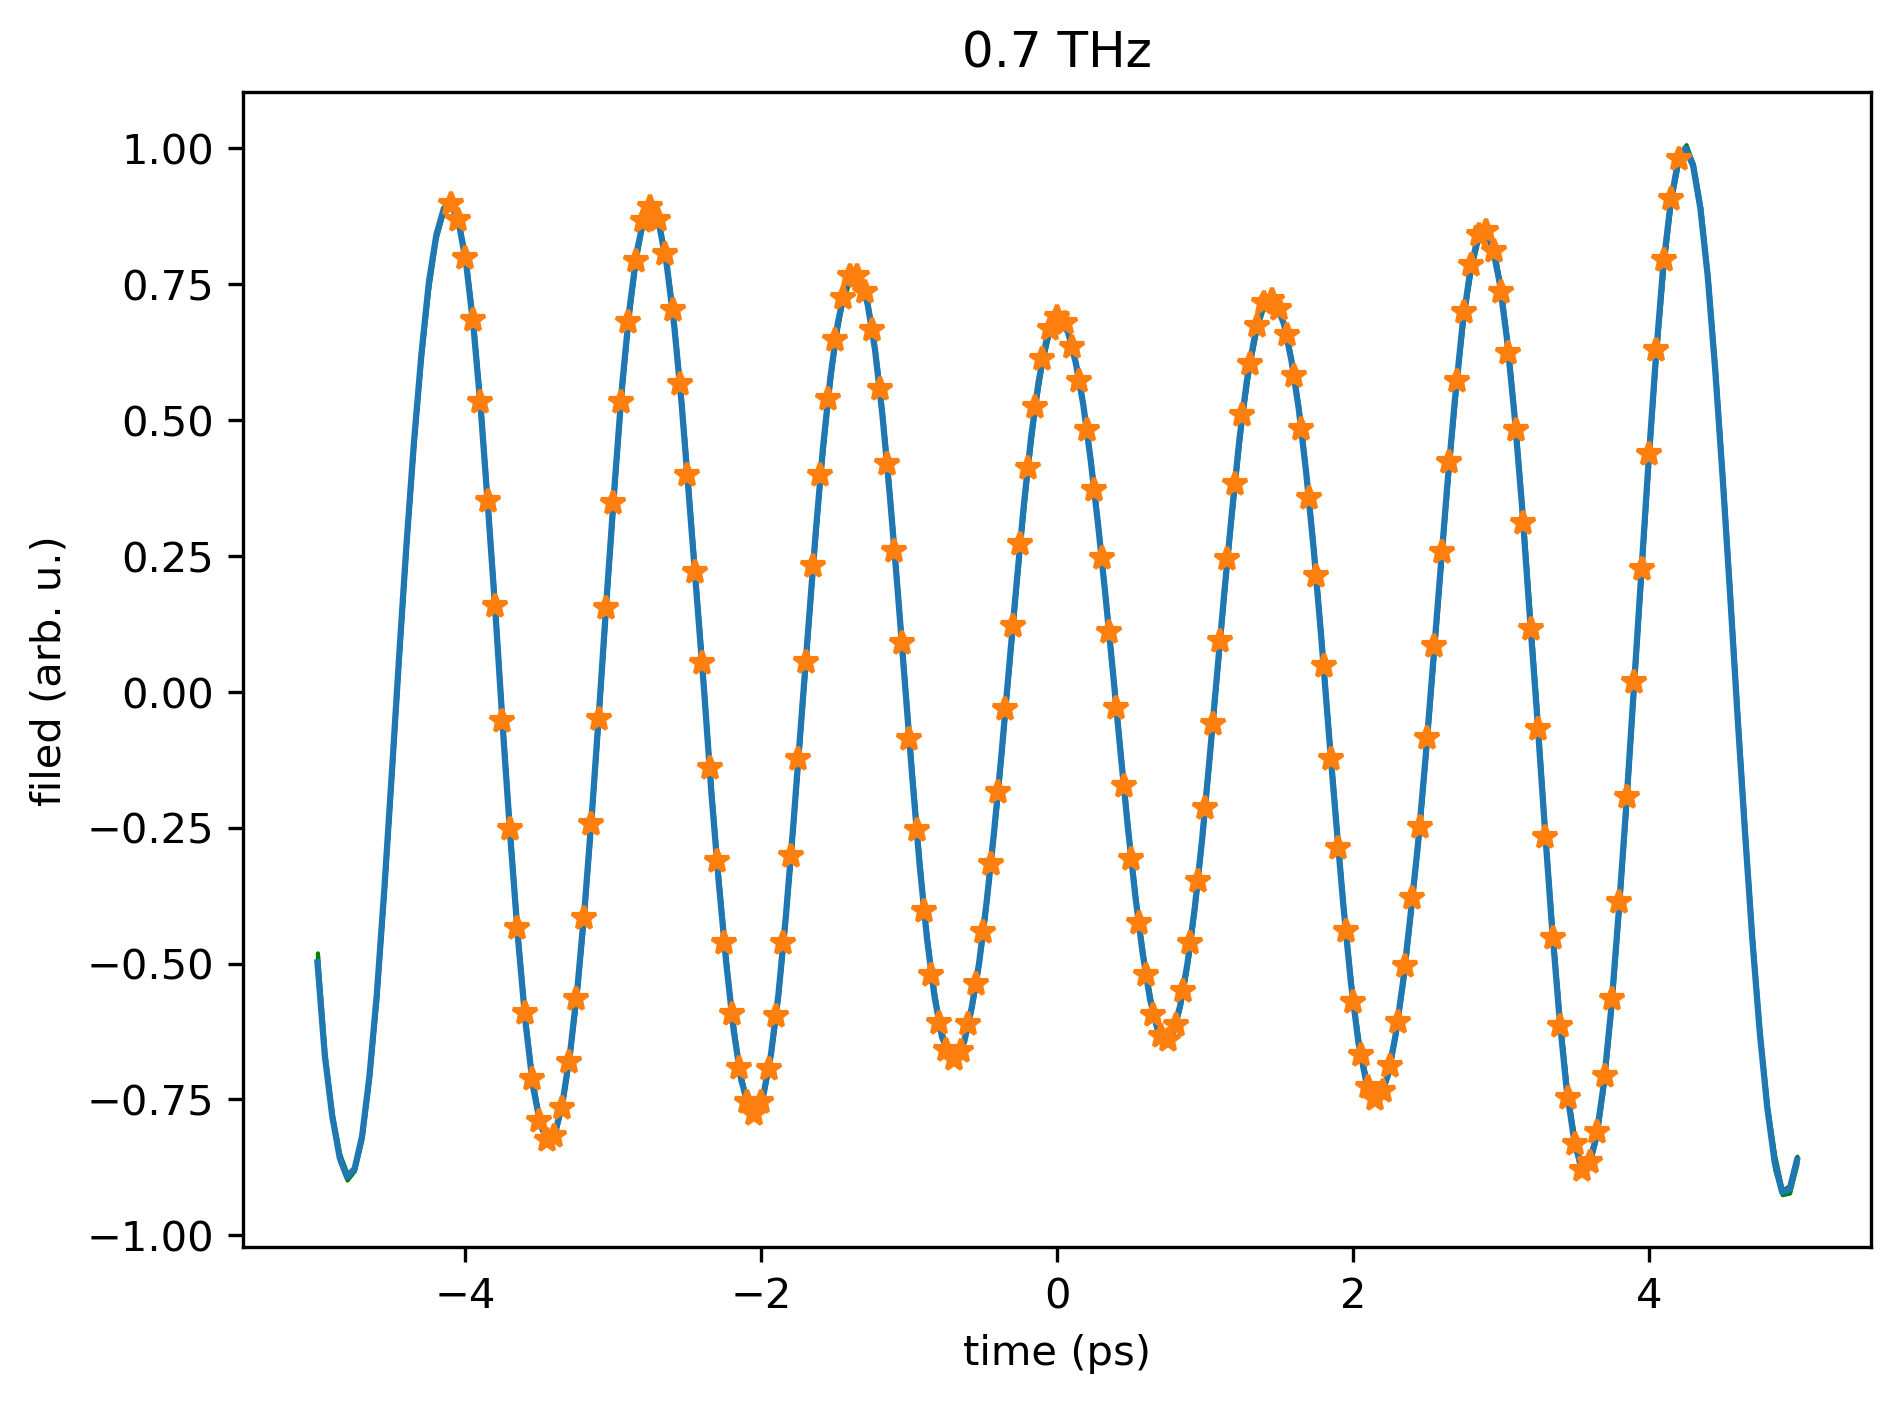

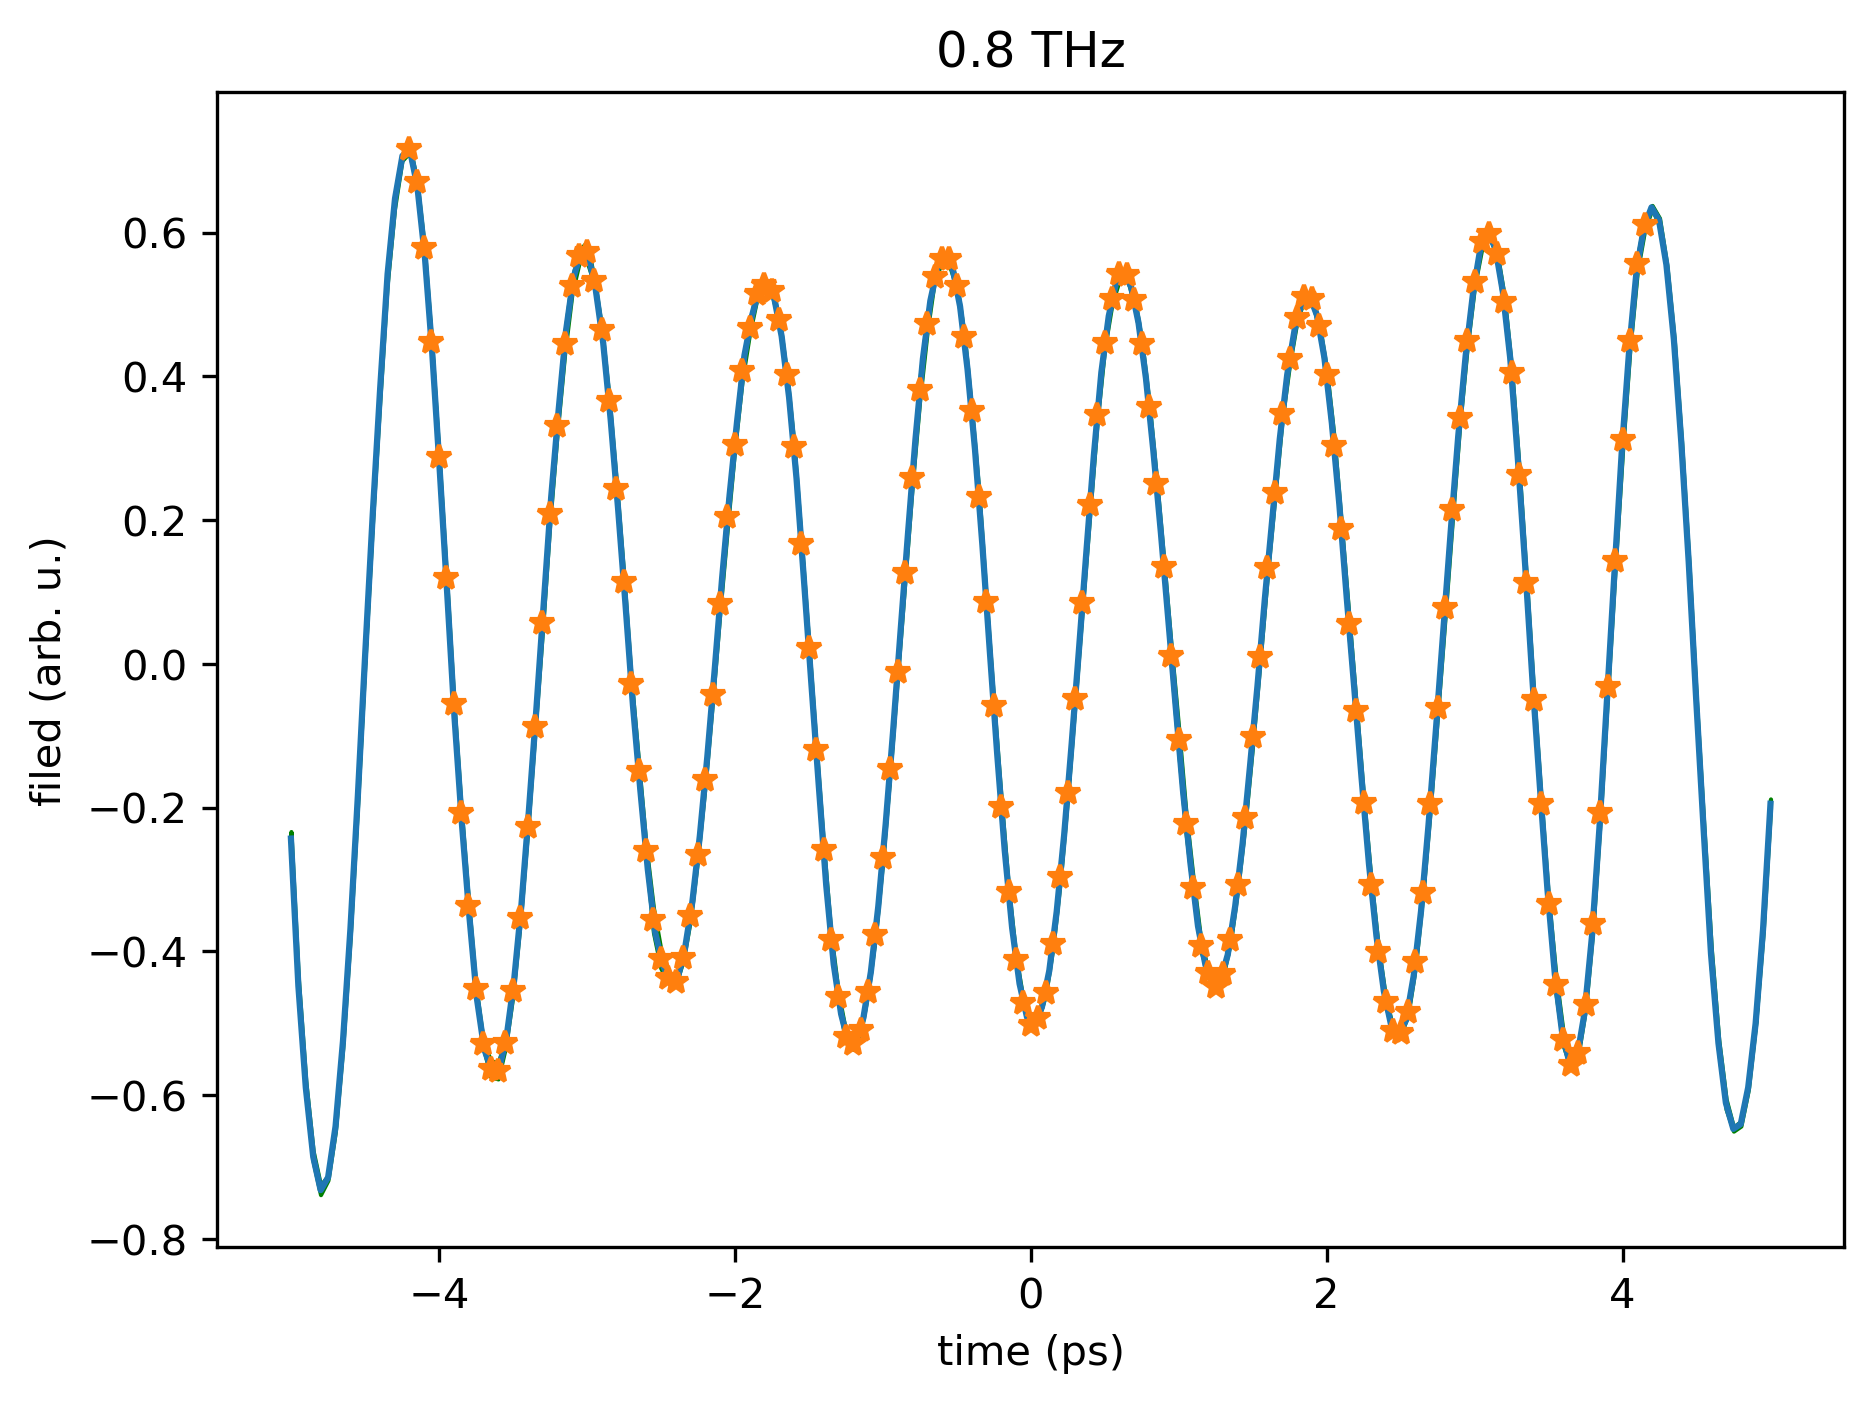

In [5]:
# Plot pulses
for freq, data in pulses.items():
    
    plt.figure(figsize=(7, 5), dpi=300)
    plt.title(freq)
    
    #plt.plot(data.time,  data.field, '.-')
        
    plt.fill_between(
        data.time, 
        data.err_lower_bound(data.time), 
        data.err_upper_bound(data.time),
        color='g',
        #alpha=0.2,
    )
    
    t = np.linspace(time.min(), time.max(), 200)
    plt.plot(t, data.interp_field(t))
    
    plt.plot(data.time_range, data.interp_field(data.time_range), '*')
    
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()  

In [6]:
np.any(np.isnan(pulses['0.5 THz']._individual_fields))

False

### Manually extract observational time window 

0.6000000000000001


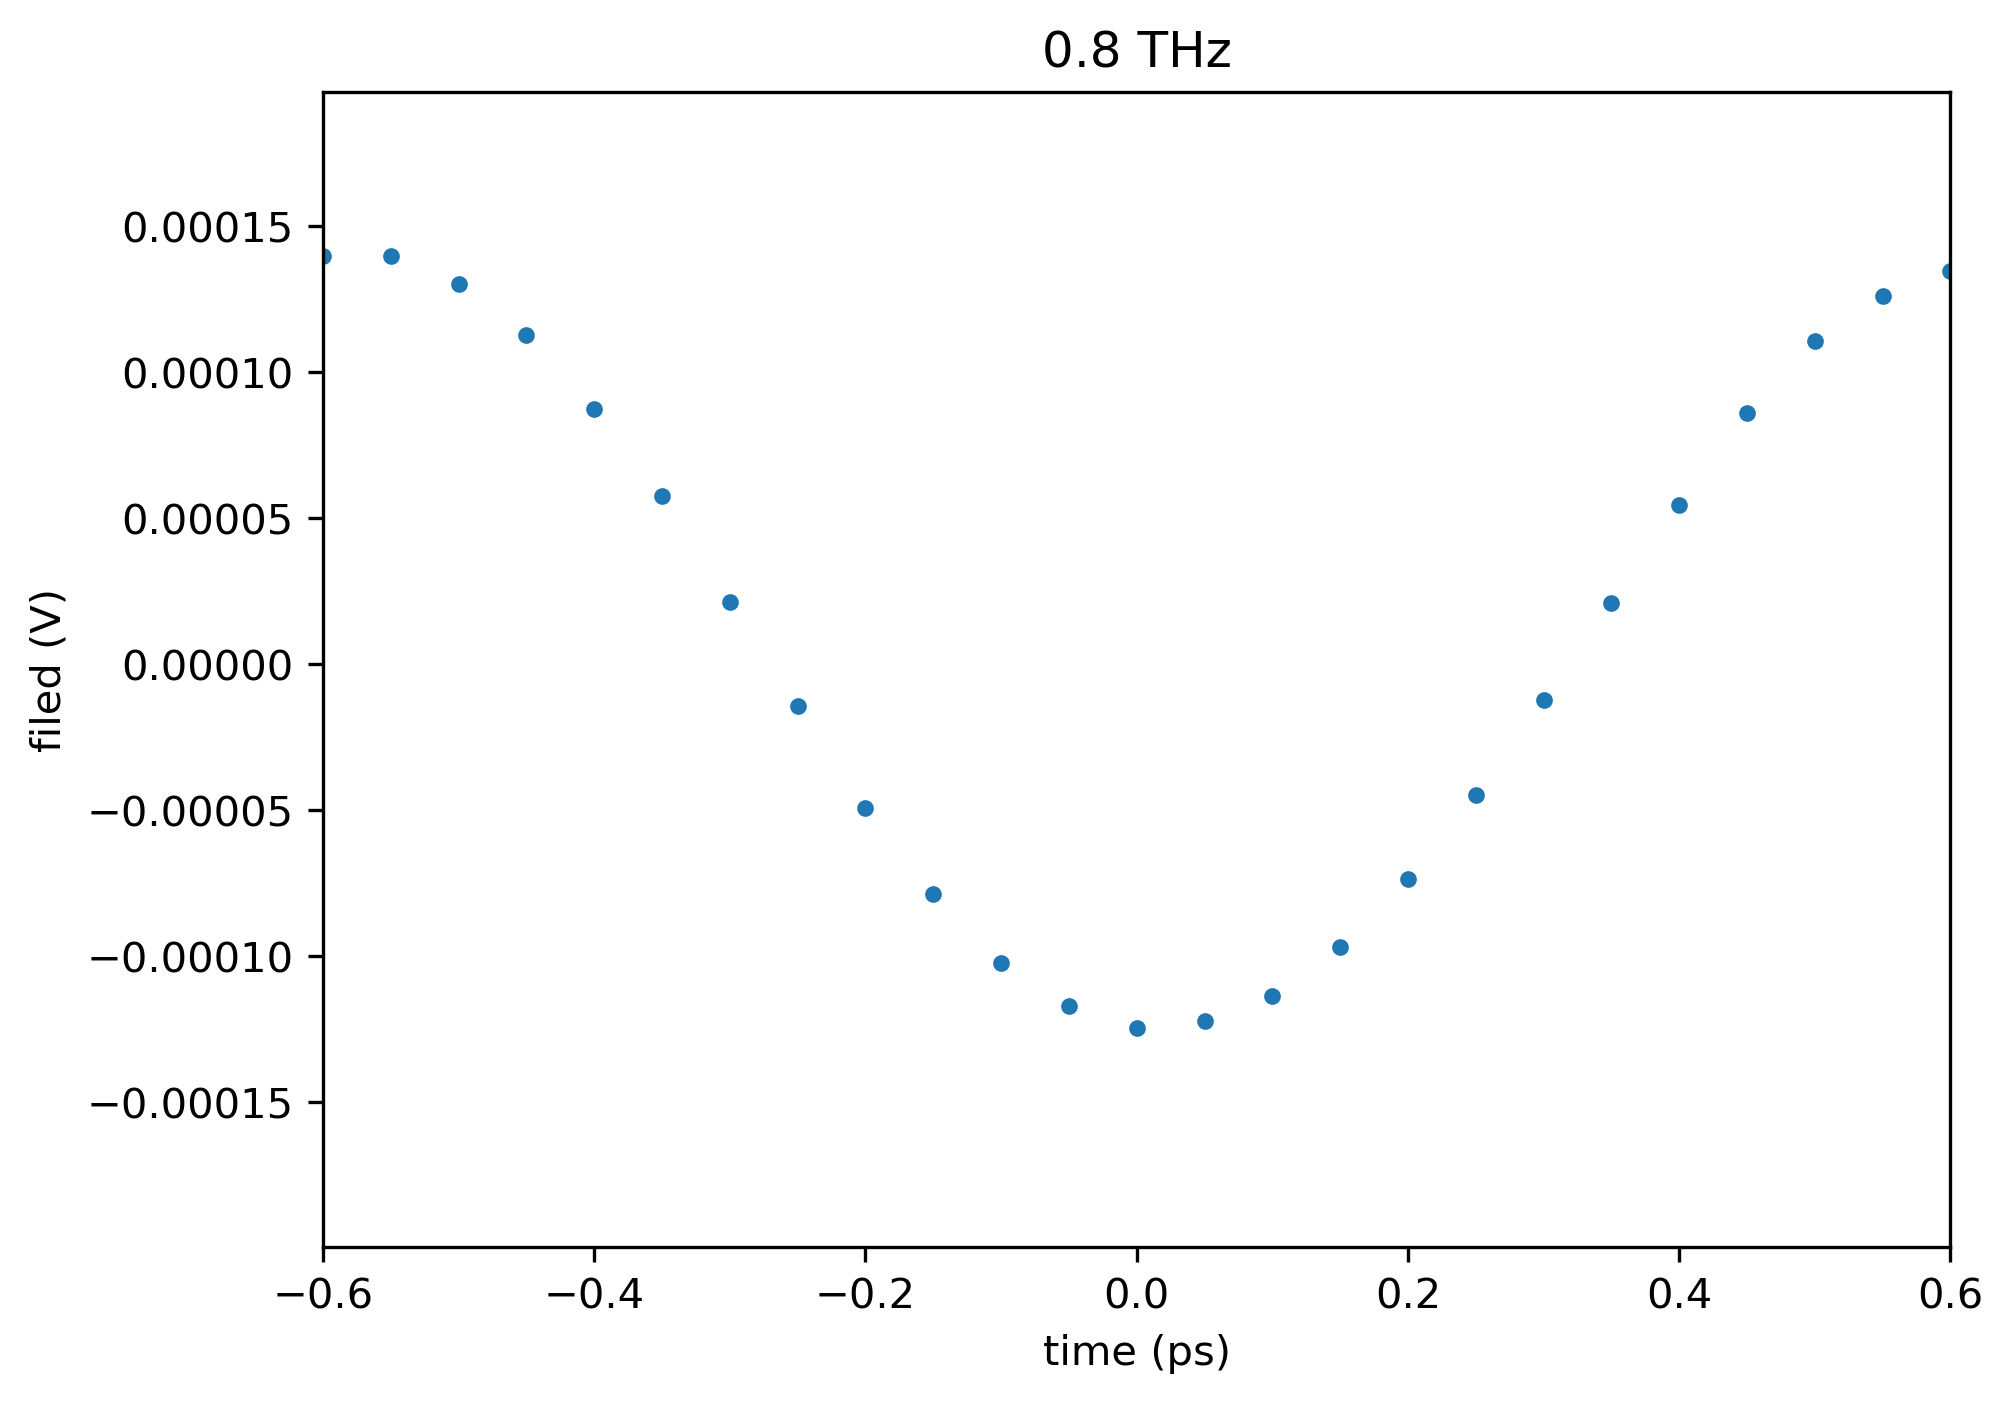

In [7]:
plt.figure(figsize=(7, 5), dpi=300)
    
field = pulses[largest_freq].field
half_period = pulses[largest_freq].half_period

print(half_period)

plt.plot(time, max_ampl * field, '.')

observational_window = -half_period, half_period

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

In [8]:
1/0.8

1.25

### Plot all pulses within the observational window

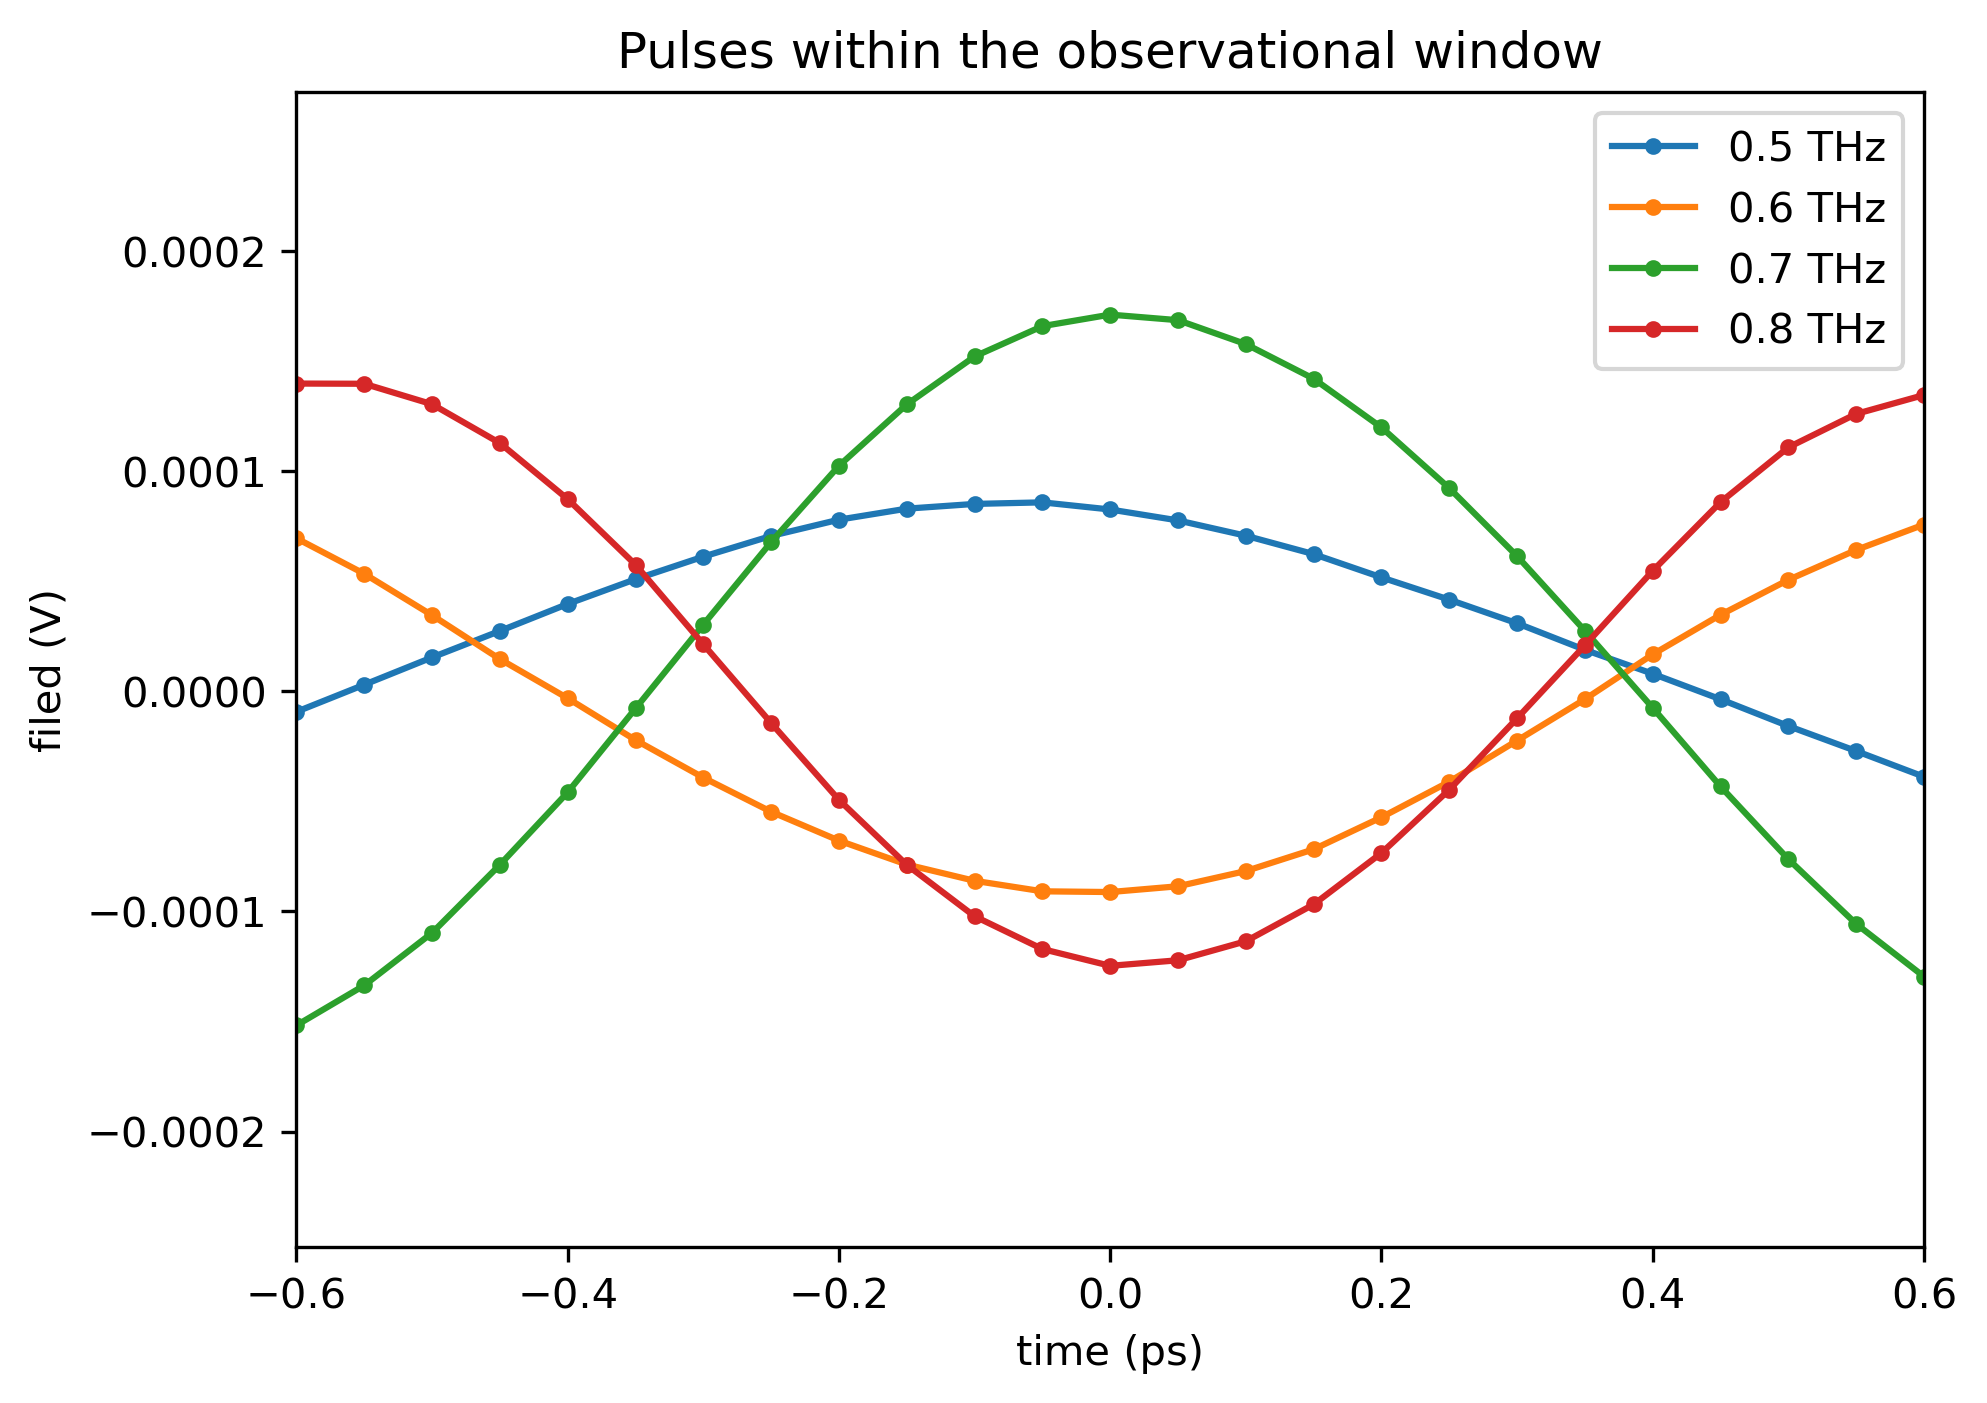

In [9]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, data in pulses.items():
    plt.plot(data.time, max_ampl * data.field, '.-', label=freq)
    

#plt.plot(combined_pulse.time, combined_pulse.field, '.-', color='black', label='experimental pulse')
    
plt.xlim(np.array(observational_window))
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')    

plt.legend()
plt.show()  

# Calculate superoscillations 

Time window for constructing superoscilations

In [10]:
half_period = pulses[largest_freq].half_period
time_window, dx = np.linspace(-half_period, half_period, 100, retstep=True)

time_window_raw = time[(time >= -half_period) & (time <= half_period)] 

## Get superoscilationsby using time delays only 

In [11]:
def get_combined_field(time_delays, time_window):
    return sum(
        _.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())
    )

def inegral_without_ampl_modulation(time_delays):
    
    return simps(get_combined_field(time_delays, time_window) ** 2, dx=dx)

def jac_inegral_without_ampl_modulation(time_delays):
        
    E = get_combined_field(time_delays, time_window)
    
    return np.array([     
        -2. * simps(E * _.interp_field.derivative()(time_window - delay), dx=dx) 
        for delay, _ in zip(time_delays, pulses.values())
    ])

# Calculate superoscillations via Gradient descent 

Randomly generate the initial conditions

In [12]:
np.random.seed(3112022)

bounds = [(_.peaks_time.min(), _.peaks_time.max()) for _ in pulses.values()]

rand_initial_guess = np.array([
    np.random.uniform(_[0], _[1], 200 * cpu_count()) for _ in bounds
])

rand_initial_guess = set(tuple(_) for _ in rand_initial_guess.T)
len(rand_initial_guess)

22400

Perform an ensemble of bounded gradient decent minimizations

In [13]:
def local_minimization(initial_time_delays):
    result = minimize(
        inegral_without_ampl_modulation,
        initial_time_delays,
        #jac = jac_inegral_without_ampl_modulation,
        bounds=bounds,
        options={'maxiter': 1000},
    )
    
    # There is 2 decimal precision in the experiment 
    time_delays = np.round(result.x, 2)
    
    return inegral_without_ampl_modulation(time_delays), tuple(time_delays)

with Pool(cpu_count()) as pool:
    gradient_descent_results = set(pool.map(local_minimization, rand_initial_guess))

Post-process results

In [14]:
gradient_descent_results = sorted(gradient_descent_results)
intensity_without_ampl_modulation, all_time_delays = zip(*gradient_descent_results)

Extract the best candidates for getting superoscilations  

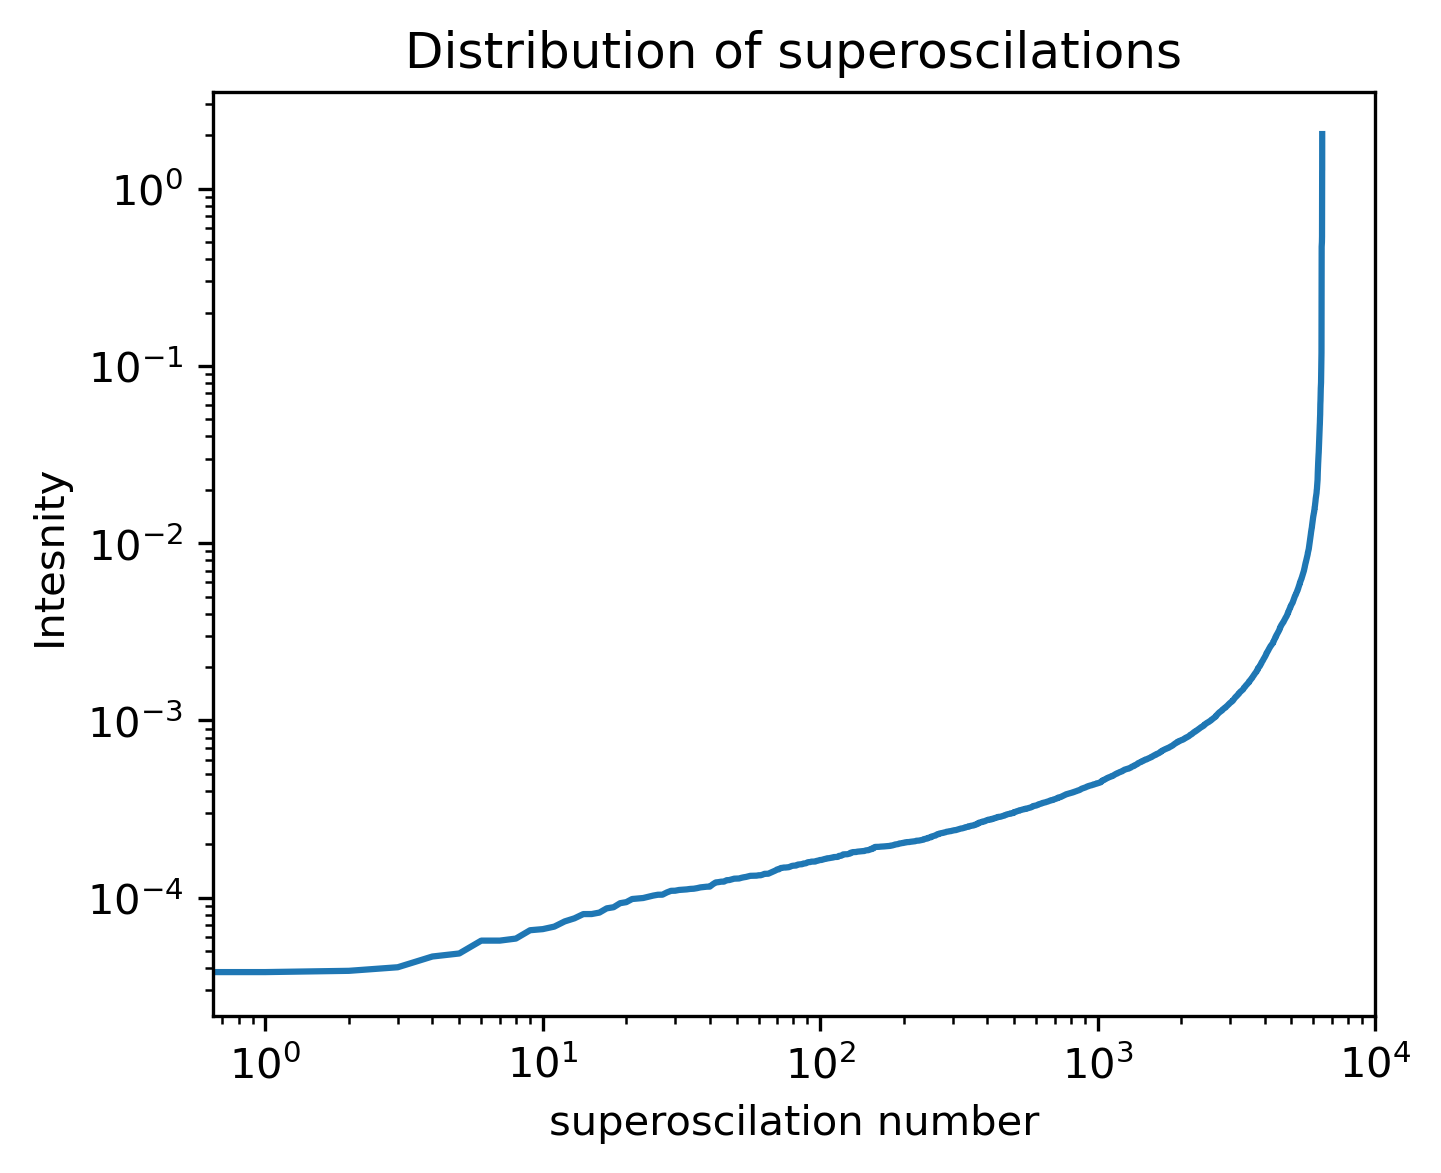

In [15]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_without_ampl_modulation)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

In [16]:
def get_err_combined_field(time_delays, time_window):
    return np.sqrt(sum(
        (_.err_upper_bound(time_window - delay) - _.err_lower_bound(time_window - delay) )** 2 
            for delay, _ in zip(time_delays, pulses.values())
    ))

In [17]:
def plot_predictions(all_time_delays):
    
    plt.figure(figsize=(10,4), dpi=300)
    plt.title("Best superoscilations")

    plt.subplot(121)

    long_time_window = 10 * time_window

    for n, time_delays in enumerate(all_time_delays[:3]):
        #plt.plot(long_time_window, get_combined_field(time_delays, long_time_window), label="theory {}".format(n))
        plt.errorbar(
            long_time_window, 
            get_combined_field(time_delays, long_time_window), 
            yerr = get_err_combined_field(time_delays, long_time_window),
            label="theory {}".format(n)
        )


    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. units)')
    plt.legend()

    plt.subplot(122)

    for n, time_delays in enumerate(all_time_delays[:3]):
        line = plt.plot(
            time_window, get_combined_field(time_delays, time_window), label="theory {}".format(n))
        line = line[0]

        # display raw points
        plt.errorbar(
            time_window_raw, 
            get_combined_field(time_delays, time_window_raw), 
            yerr = get_err_combined_field(time_delays, time_window_raw),
            color = line.get_color(),
            marker='*',
            linestyle=' ',
        )

    plt.gca().twinx().plot(
        time_window, 
        pulses[largest_freq].interp_field(time_window), 
        'k-',
        label=largest_freq,
    )
        
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. units)')
    plt.legend()

    plt.tight_layout()

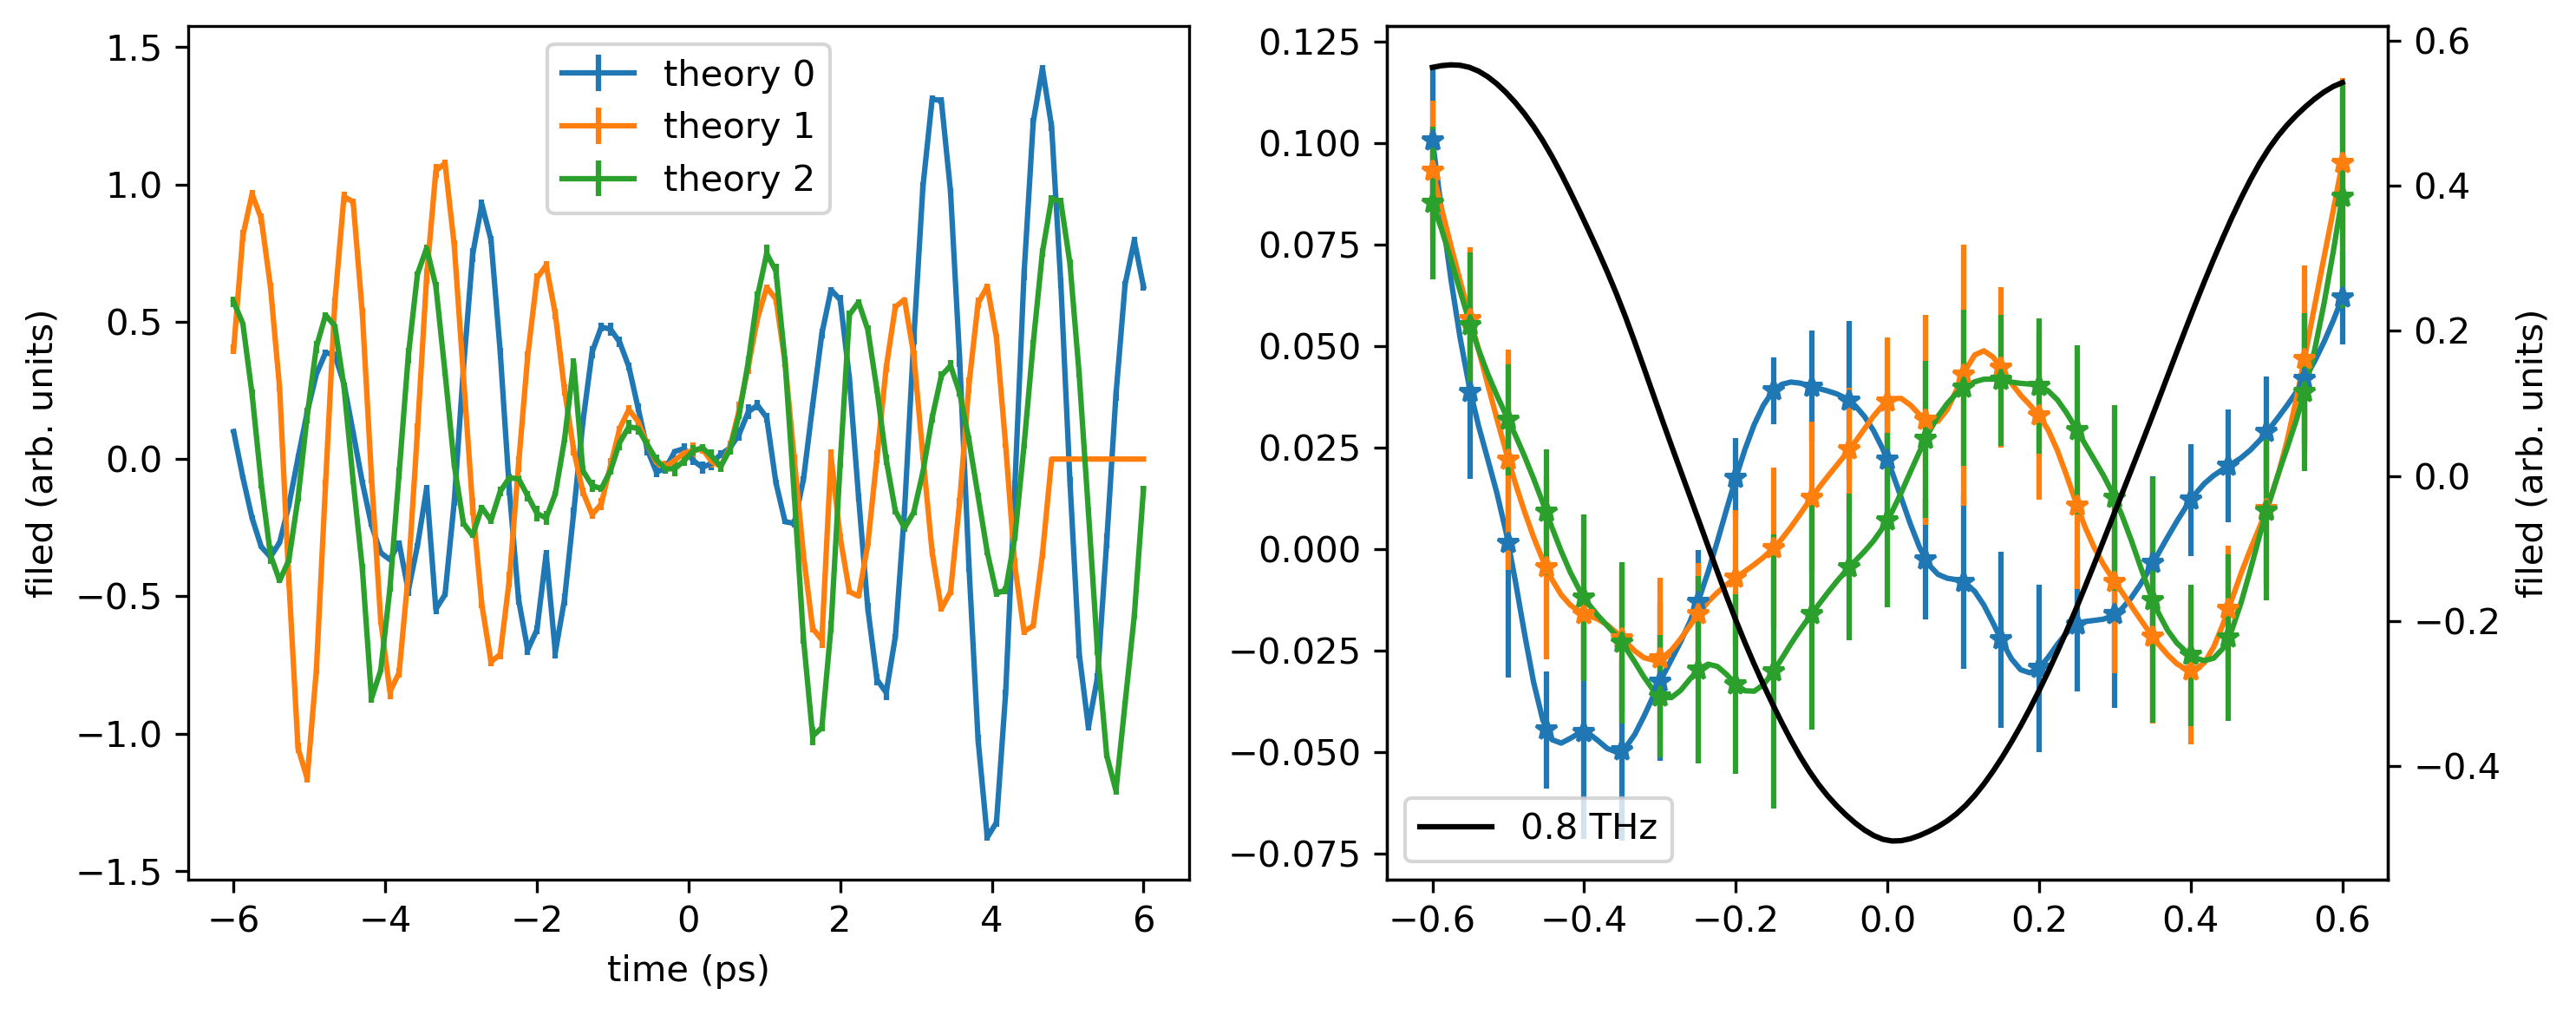

In [18]:
plot_predictions(all_time_delays[3000:])

plt.savefig(get_unique_filename("gradient_descent_so_{}.png"))

plt.show()  

In [19]:
#all_time_delays[3000:3003]
all_time_delays = np.array(all_time_delays)
all_time_delays[3000:3003] = np.array([[-0.29,  0.06,  0.39,  2.87],
       [-2.64, -3.47,  4.03, -0.09],
       [-2.61,  3.95,  0.46, -0.84]])

all_time_delays[3001]

array([-2.64, -3.47,  4.03, -0.09])

## Comparing with experimental data

In [20]:
def load_experimental_so(file_template):
    
    # load file names matching the pattern
    filenames = sorted(glob.glob(folder_data + file_template))
    
    if len(filenames) == 0:
        # Nothing to load
        return
    
    all_data = [np.loadtxt(_).T[:-1] for _ in filenames]
    
    times, _individual_fields = zip(*all_data)
    
    _individual_fields = np.array(_individual_fields)
    
    time = times[0]
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"

    #  Checking whether the time axis coincide
    assert all(np.allclose(time, _) for _ in times), \
        "This workbook cannot be used since the time data is not syncronized"
    
    field = np.mean(_individual_fields, axis=0)
    
    # Substract the mean from experimental fields to compensate for parasitic offset
    field -= field.mean()
    
    # calculate the confidence interval
    err_lower_bound, err_upper_bound = stats.t.interval(
        confidence_level, 
        _individual_fields.shape[0], 
        field, 
        stats.sem(_individual_fields, axis=0)
    )
    
    # Saving the data 
    return Pulse(
        time = time, 
        field = field / max_ampl,
        _individual_fields = _individual_fields,
        err_lower_bound = err_lower_bound / max_ampl,
        err_upper_bound = err_upper_bound / max_ampl,
    )

Loading data

In [21]:
gradient_short_experimental_so = [load_experimental_so('/gradient/gradient_t{}_short_*.dat'.format(_)) for _ in range(3)]
gradient_short_experimental_so = [_ for _ in gradient_short_experimental_so if _]

gradient_long_experimental_so = [load_experimental_so('/gradient/gradient_t{}_long_*.dat'.format(_)) for _ in range(3)]
gradient_long_experimental_so = [_ for _ in gradient_long_experimental_so if _]

Plotting short and long measurement at the same time  

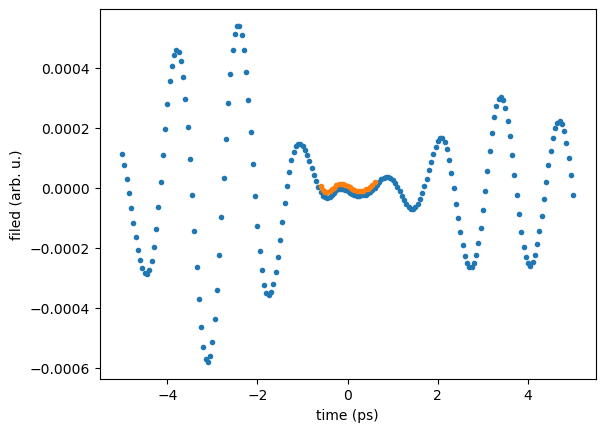

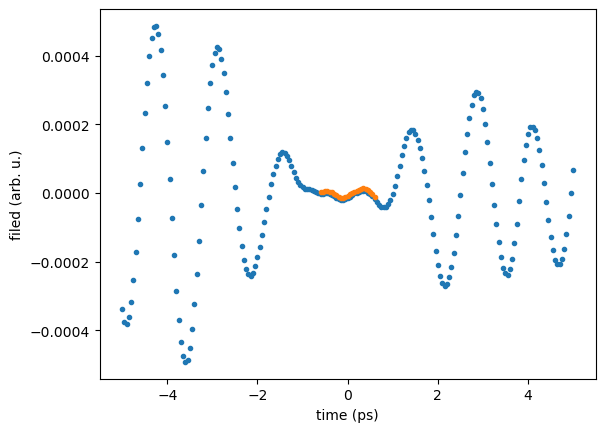

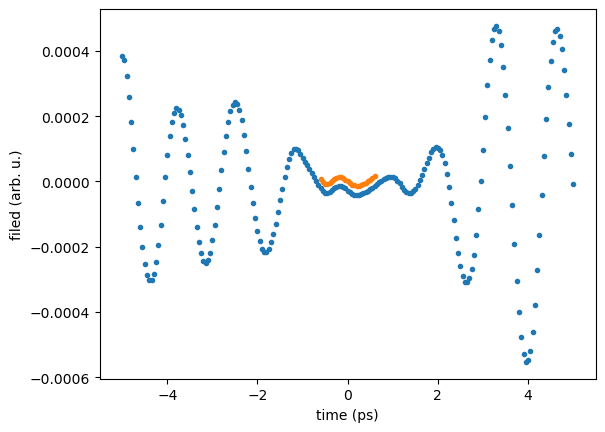

In [22]:
for long, short in zip(gradient_long_experimental_so, gradient_short_experimental_so):
    plt.plot(long.time, max_ampl * long.field, '.')
    plt.plot(short.time, max_ampl * short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()

## Local frequency analysis

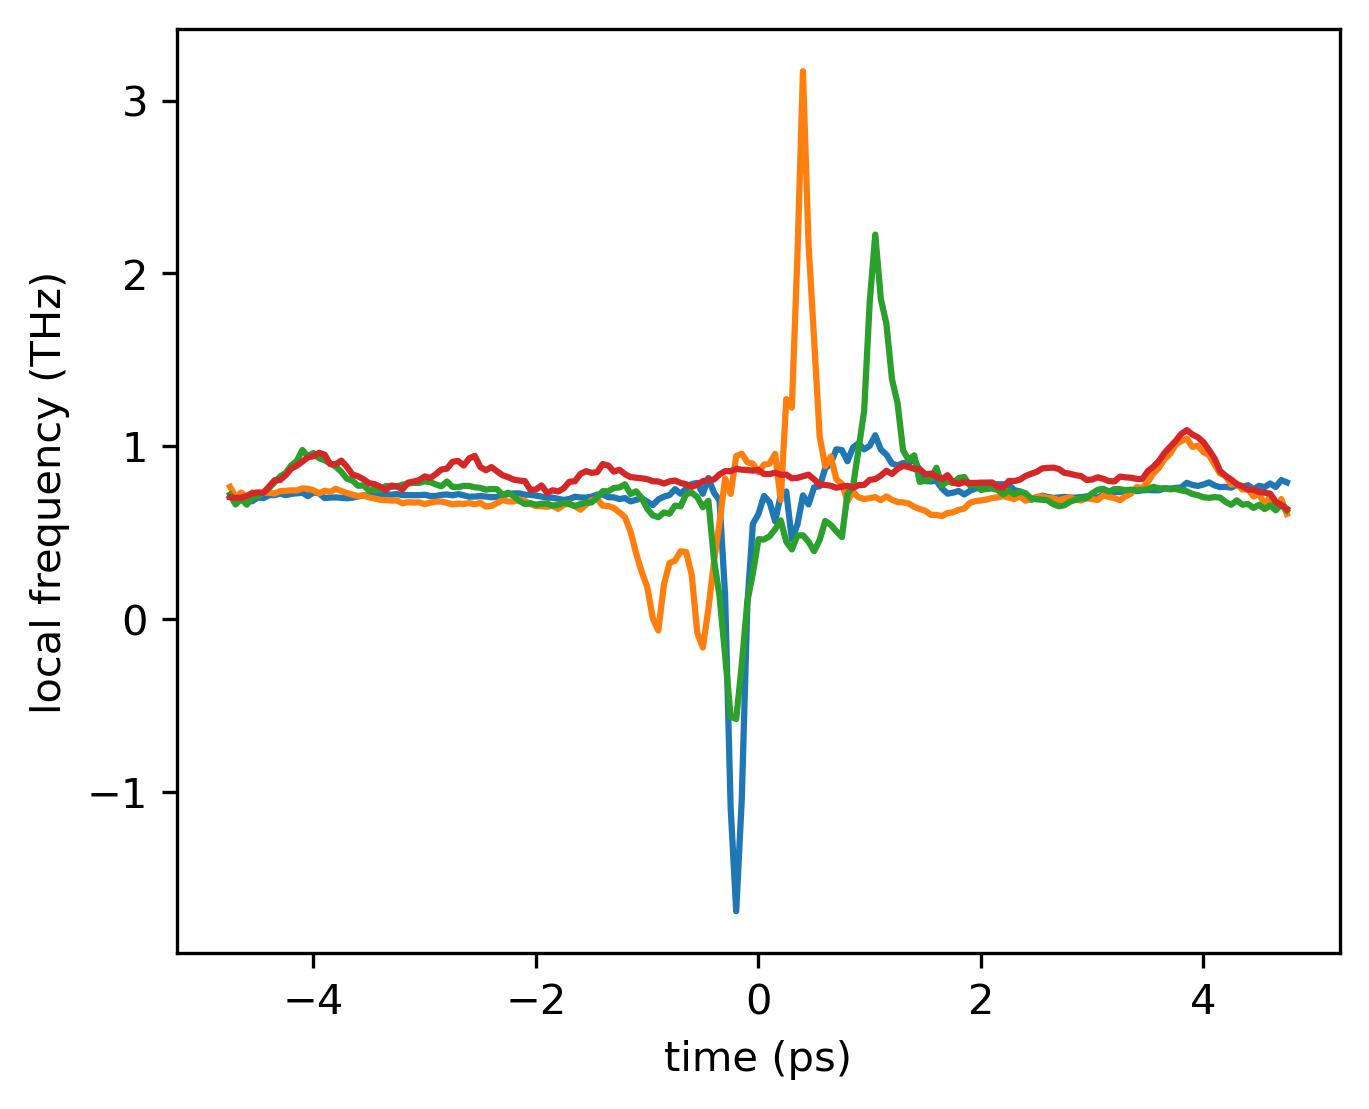

In [23]:
def get_local_freq(pulse):
    
    phase = np.unwrap(np.angle(hilbert(pulse.field)), discont=np.pi/2)
    return np.gradient(phase, np.pi / (pulse.time.max() - pulse.time.min()))

plt.figure(figsize=(5,4), dpi=300)

for long in gradient_long_experimental_so:
    plt.plot(long.time[5:-5], get_local_freq(long)[5:-5])
    
t = pulses[largest_freq].time
plt.plot(t[5:-5], get_local_freq(pulses[largest_freq])[5:-5], label=largest_freq)
    
    
#plt.plot([t[5], t[-5]], [0.8, 0.8])
    
plt.xlabel('time (ps)')
plt.ylabel('local frequency (THz)')

plt.show()

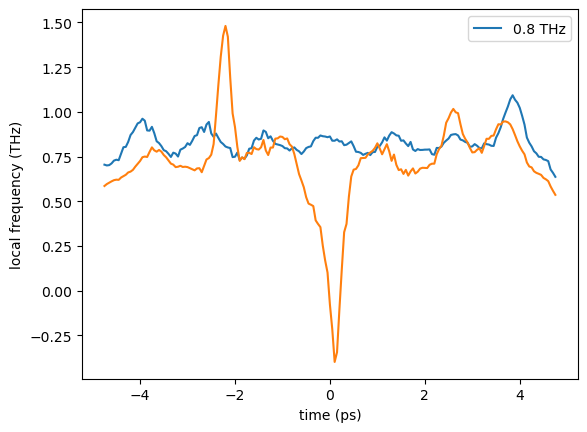

In [24]:
t = pulses[largest_freq].time
plt.plot(t[5:-5], get_local_freq(pulses[largest_freq])[5:-5], label=largest_freq)


combined_pulse = Pulse(field = get_combined_field([0, 0, 0, 0], t), time = t)

plt.plot(t[5:-5], get_local_freq(
    combined_pulse
)[5:-5])    
#plt.plot([t[5], t[-5]], [0.8, 0.8])
    
plt.xlabel('time (ps)')
plt.ylabel('local frequency (THz)')
plt.legend()
plt.show()

In [90]:
def plot_predictions_vs_experiment(all_time_delays, long_experimental_so, short_experimental_so):
    
    long_time_window = 10 * time_window

    data_plotting = list(zip(all_time_delays, long_experimental_so, short_experimental_so))
    n_plots = len(data_plotting)


    fig, axs = plt.subplots(n_plots, 3, figsize=(11, 2 * n_plots), dpi=200)

    
    alphabet = list('adgbehcfi')[::-1] #list('abcdefghijklmnopqrstuvwxyz')[::-1]


    for n, (time_delays, long, short,) in enumerate(data_plotting):

        
        #plt.title("Best superoscilations")

        axs[n, 0].plot(
            long_time_window, 
            get_combined_field(time_delays, long_time_window), 
            label="theory"
        )
        
        axs[n, 0].errorbar(
            long.time, 
            long.field, 
            yerr=long.err_upper_bound - long.err_lower_bound,
            ls=' ',
            marker='.',
            label="experiment",
            color='tab:orange',
        )
        
        axs[n, 0].set_xlabel('$t$ (ps)')
        axs[n, 0].set_ylabel('$E(t)$ (arb. u.)')
        axs[n, 0].set_xlim([-4, 4])

        axs[n, 0].text(0.5, 0.1, "({})".format(alphabet.pop()),  transform=axs[n, 0].transAxes)
        
        field = get_combined_field(time_delays, time_window)
        
        error = get_err_combined_field(time_delays, time_window)
        axs[n, 1].fill_between(
            time_window, 
            field - error, 
            field + error,
            alpha=0.6,
            label="theory"
        )
        
    
        axs[n, 1].errorbar(
            short.time, 
            short.field, 
            yerr=short.err_upper_bound - short.err_lower_bound,
            marker='.',
            label="experiment",
            color='tab:orange'
        )
        #axs[n, 1].set_ylabel('$E(t)$ (arb. u.)')
        axs[n, 1].text(0.9, 0.1, "({})".format(alphabet.pop()),  transform=axs[n, 1].transAxes)
    
        
        axs[n, 1].set_xlim([-0.6, 0.6])
        axs[n, 1].set_ylim([-0.1, 0.1])
        
        
        ####################################################################################

        for poin in product([-0.6], [-0.1, 0.1]):
            fig.add_artist(
                ConnectionPatch(
                    xyA=poin, coordsA=axs[n, 0].transData,
                    xyB=poin, coordsB=axs[n, 1].transData,
                    arrowstyle="-|>", 
                    shrinkB=30,
                    color='tab:grey',
                    ls='--'
                )
            )
      
        axs[n, 0].add_patch(
                plt.Rectangle([-0.6, -0.1,], 1.2, 0.2, fill=None)
        ) 
       
        ####################################################################################
        ax = axs[n, 1].twinx() 
        color = 'tab:green'

        #ax.set_ylabel('Electric filed (arb. u.)', color=color)
        ax.plot(
            short.time, 
            pulses[largest_freq].interp_field(short.time),
            color=color,
            #label=largest_freq,
            label='0.82 THz',
        )
        ax.tick_params(axis='y', labelcolor=color)
        if n == 0:
            ax.legend(loc='upper center')
            
        # local freqyency analysis
        axs[n, 2].plot(long.time[5:-5], get_local_freq(long)[5:-5], color='tab:orange')
        axs[n, 2].plot(
            pulses[largest_freq].time[5:-5], 
            get_local_freq(pulses[largest_freq])[5:-5], 
            #label=largest_freq + ' pulse',
            color=color,
        )
        axs[n, 2].set_ylabel(r'$f_{\rm loc}$ (THz)')
        axs[n, 2].set_xlim([-4, 4])
        
        axs[n, 2].text(0.9, 0.1, "({})".format(alphabet.pop()),  transform=axs[n, 2].transAxes)

    for ax in axs[:, 0]:
        ax.label_outer()

    for ax in axs[:-1, 1]:
        ax.set_xticklabels([])
        
    for ax in axs[:-1, 2]:
        ax.set_xticklabels([])

    axs[-1, 1].set_xlabel('$t$ (ps)')
    axs[-1, 2].set_xlabel('$t$ (ps)')

    axs[0, 0].legend(loc='upper center')

    plt.tight_layout()
   

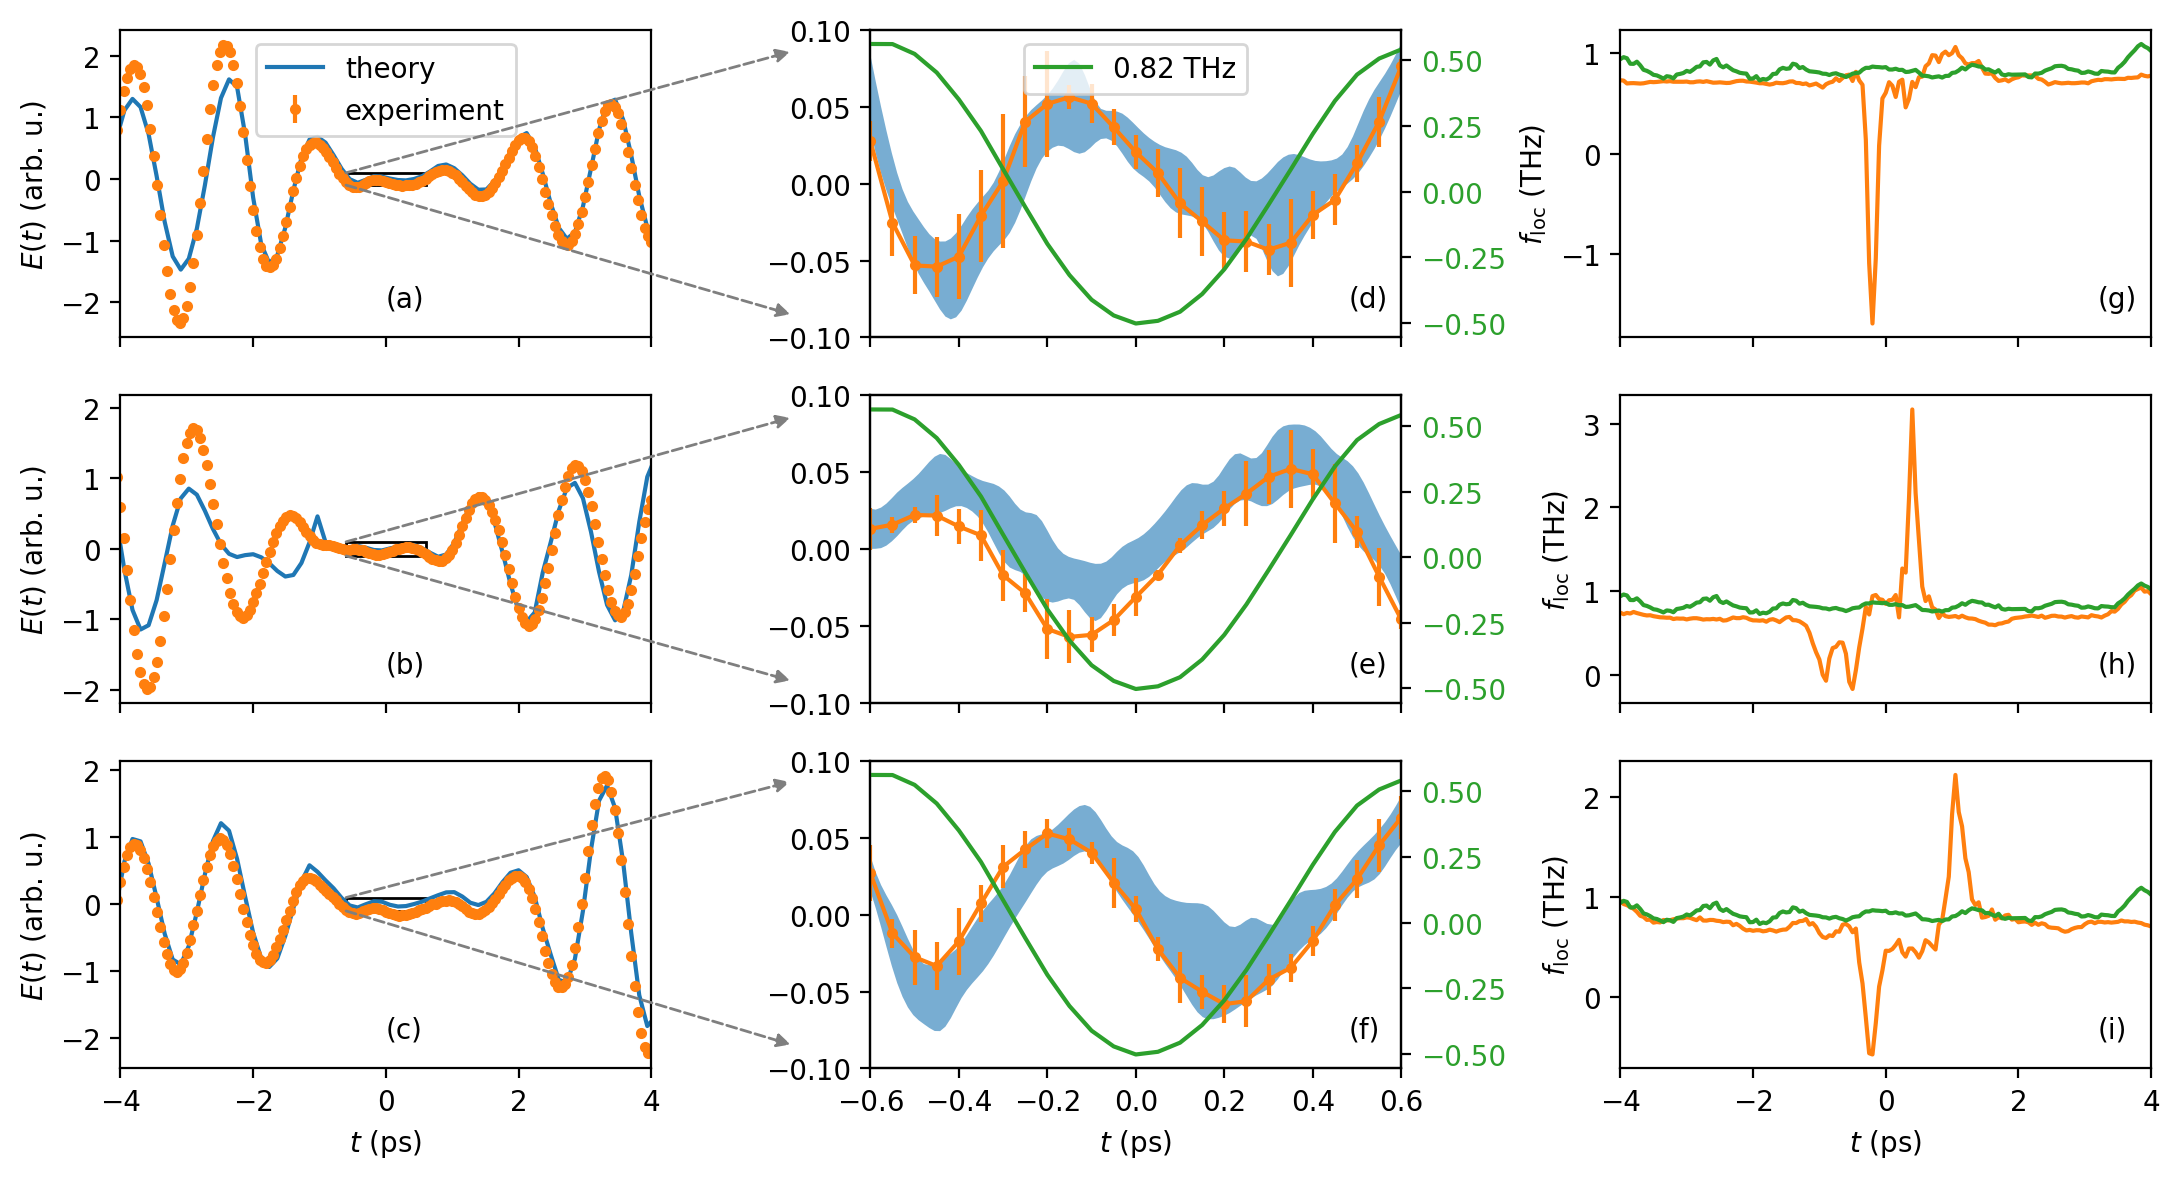

In [91]:
if gradient_long_experimental_so:
    plot_predictions_vs_experiment(
        all_time_delays[3000:3003], 
        gradient_long_experimental_so, 
        gradient_short_experimental_so
    )

    plt.savefig(get_unique_filename("gradient_so_{}.pdf"))
    plt.show() 

In [84]:
def get_multicolored_line(x, y, colour_min=0, colour_max=0.8, **kwargs):
    """
    Following the tutorial on multicolored lines 
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html
    return the line segment
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap='plasma', norm=plt.Normalize(0, 1), **kwargs)
    lc.set_array(np.linspace(colour_min, colour_max, x.size))
    lc.set_linewidth(2)
    
    return lc

def illustration_how_to_make_superoscilations(all_time_delays, ):
    
    
    t = np.linspace(time.min(), time.max(), 300)
    
    n_plots = len(all_time_delays)
    
    colouring = list(
        plt.cm.get_cmap('plasma')(np.linspace(0., 0.8, 2 * n_plots))
    )
    
    freq_label = ['0.52 THz', '0.63 THz', '0.72 THz', '0.82 THz']
    
    fig, axs = plt.subplots(n_plots, 2, figsize=(6, 1.8 * n_plots), dpi=300)
    
    
    for n, (freq, data) in enumerate(pulses.items()):
        
        
        axs[n, 0].plot(
            t, 
            data.interp_field(t), 
            '--',
            label=r"$E_{}(t)$".format(n + 1), 
            color=colouring.pop()
        )
        
        color = colouring.pop()
        
        axs[n, 0].plot(
            t +  all_time_delays[n], 
            data.interp_field(t), 
            label=r"$E_{j}(t - \tau_{j})$".format(j = n + 1), 
            color=color
        )
        
        
        axs[n, 0].legend(
            loc='upper center', 
            bbox_to_anchor=(0.5, 1.4),
            bbox_transform=axs[n, 0].transAxes,
            framealpha=1,
        )
        
        axs[n, 0].text(0.3, -0.6, freq_label[n], ha='center', va='center', color=color)
        
        
    
    t = np.linspace(time_window.min(), time_window.max(), 200)
    
    line = get_multicolored_line(t, get_combined_field(all_time_delays, t), label='$\sum_{j=1}^4 E_j(t - \tau_j)$')
    axs[-1, -1].add_collection(line)
        
    
    #axs[-1, -1].plot(
    #        t,
    #        get_combined_field(all_time_delays, t),
    #        color=colouring.pop(),
    #        label=r'$\sum_{j=1}^4 E_j(t - \tau_j)$',
    #    )
        
    axs[-1, -1].set_xlim(1.5 * time_window.min(), 1.5 * time_window.max())
    axs[-1, -1].set_ylim(-0.1, 0.1)
    axs[-1, -1].set_xlabel('$t$ (ps)')
    #axs[-1, -1].set_ylabel('Electric field (arb. u.)')
    #axs[-1, -1].legend(
    #        loc='upper center', 
    #        bbox_to_anchor=(0.5, 1.4),
    #        bbox_transform=axs[-1, -1].transAxes
    #)
    
    # Cleaning axes
    for ax in chain(axs[:, 0], axs[:-1, 1]):
        ax.set_xlim(1.5 * time_window.min(), 1.5 * time_window.max())
        ax.set_ylim(-0.8, 0.8)
        ax.set_xlabel('$t$ (ps)')
        #ax.set_ylabel('Electric field (arb. u.)')
        ax.label_outer()
        
         
    plt.tight_layout()

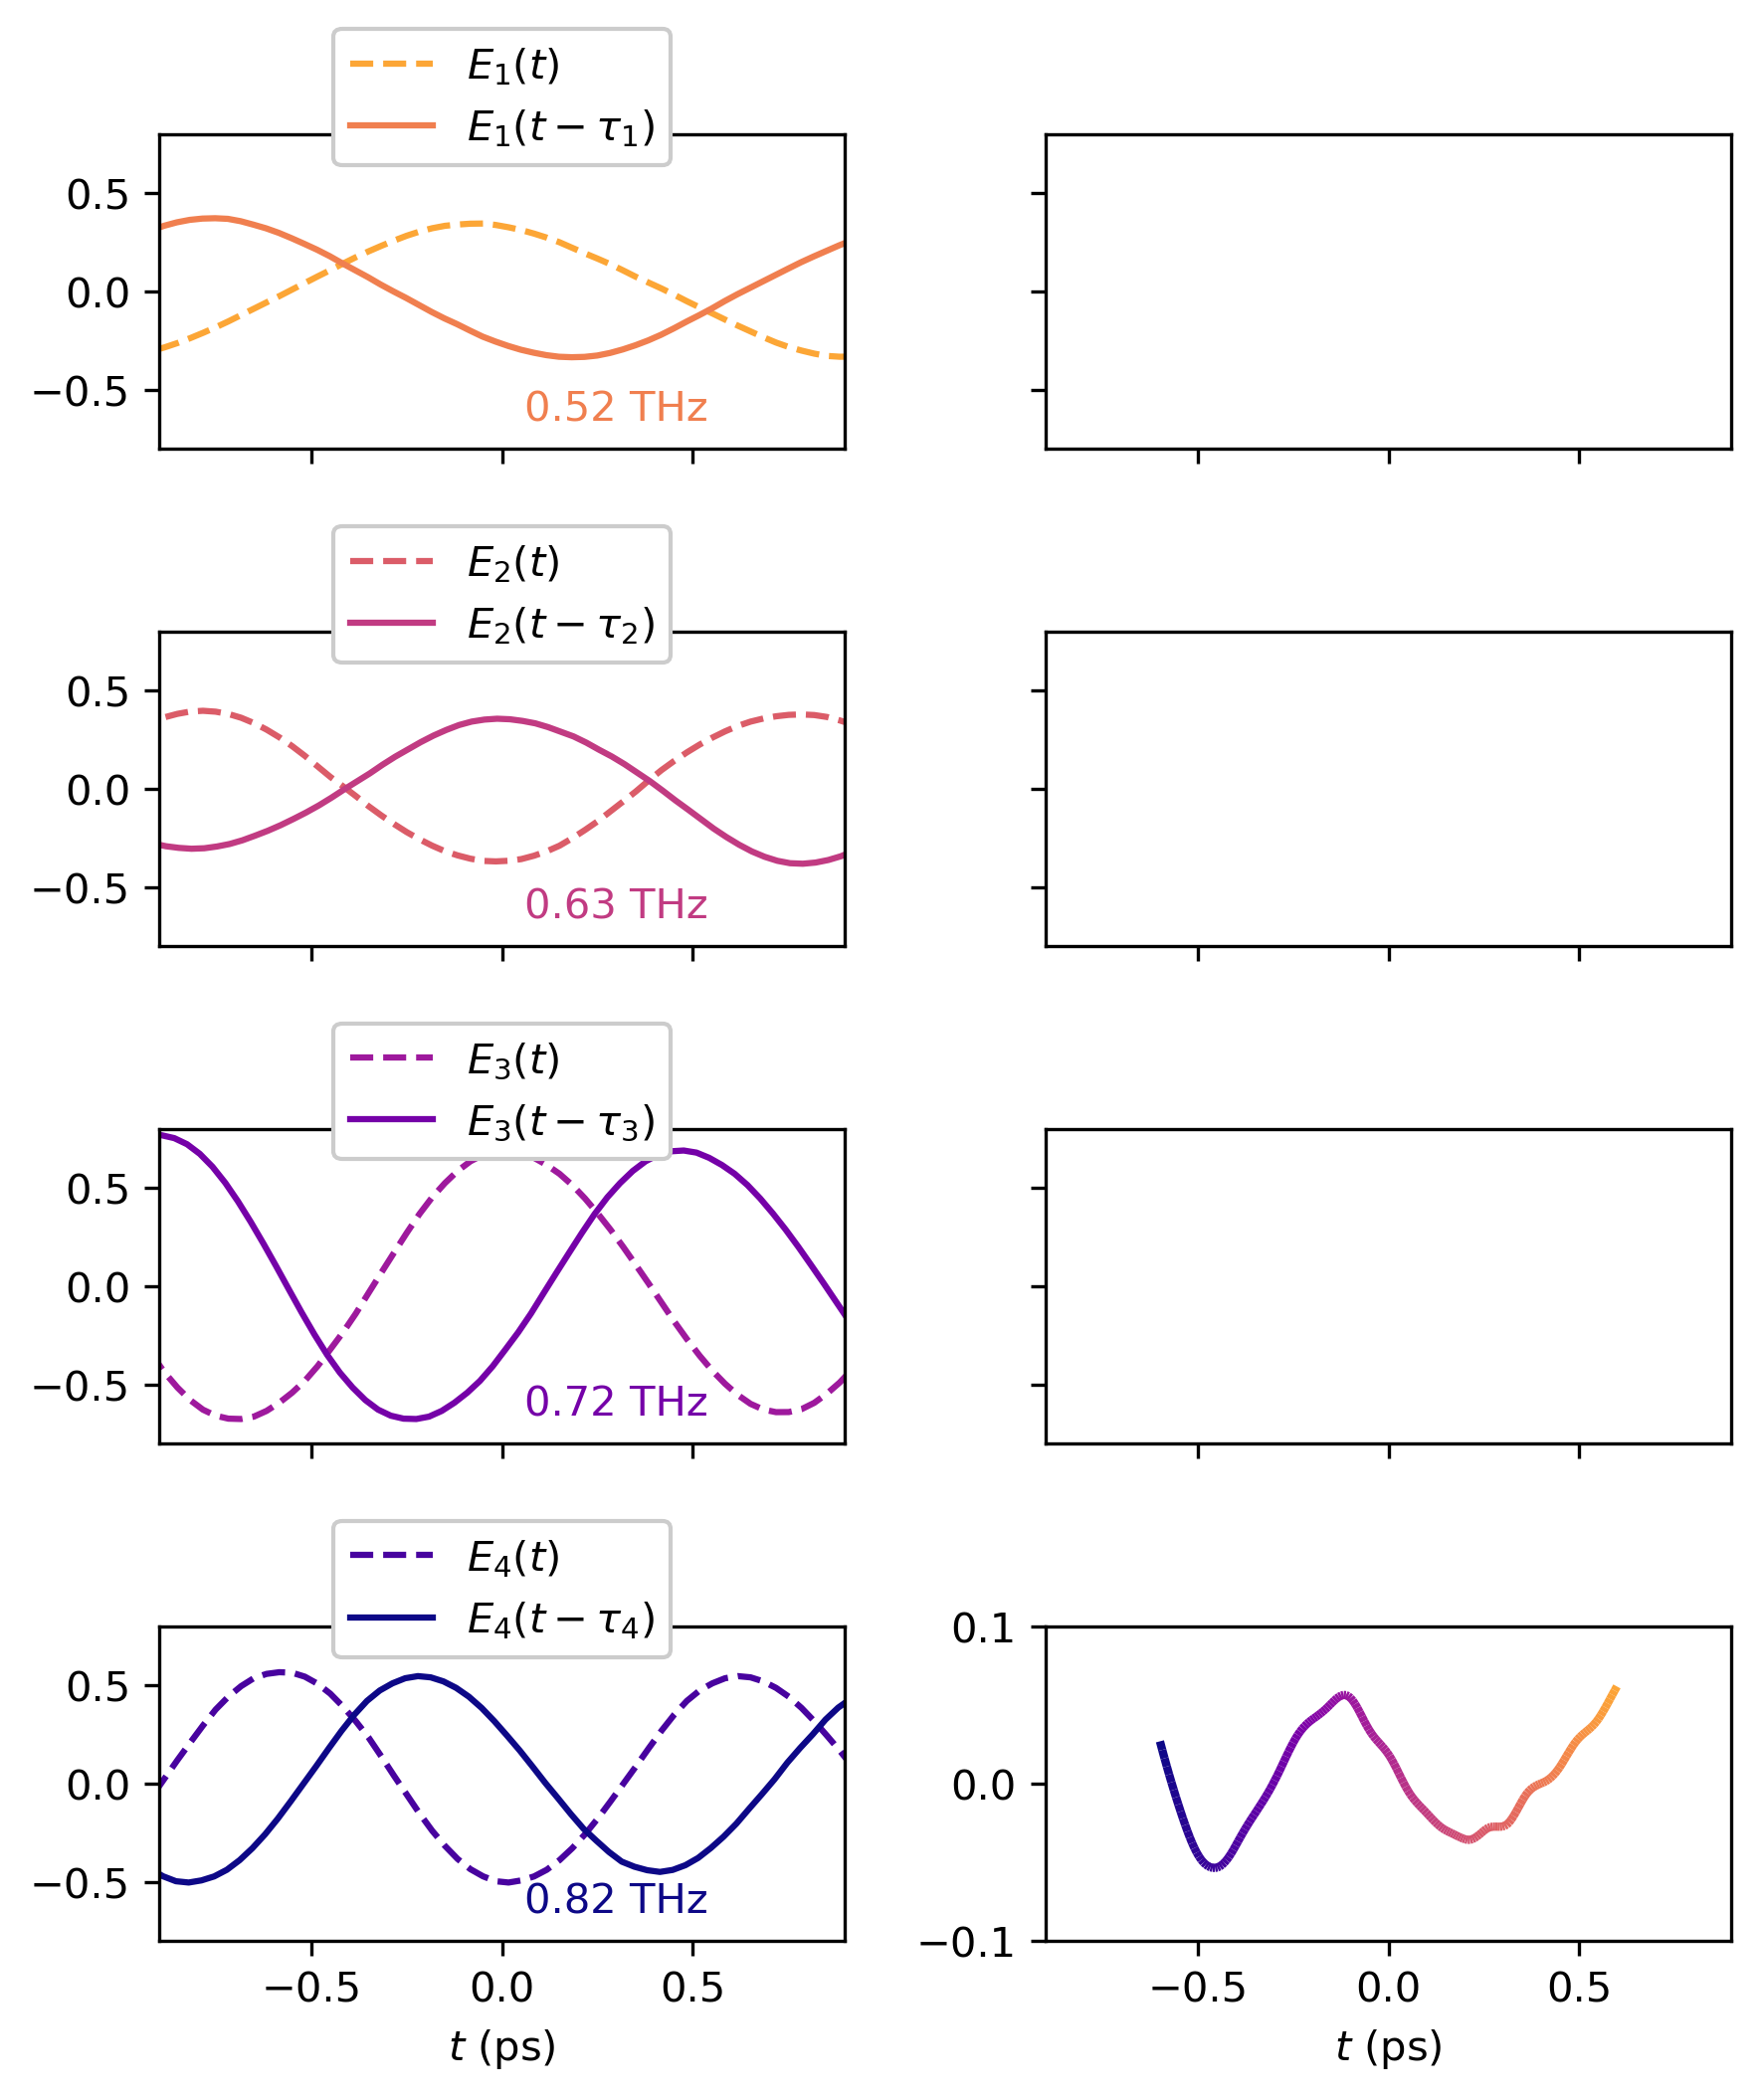

In [85]:
illustration_how_to_make_superoscilations(all_time_delays[3002])
plt.savefig("fig_algorithm1.pdf")
plt.show()

## Fourier transform of the "pure" harmonics -- Method 1

long_waveforms = []

for filename in glob.glob(folder_data + '/long_waveforms/N0_F0*_1.dat'):
    
    time_, field = np.loadtxt(filename).T[:-1]
    
    long_waveforms.append(
        Pulse(
            time = time_, 
            field = field / max_ampl,
        )
    )

long_waveforms

from scipy import fftpack

plt.figure(figsize=(7, 5), dpi=300)
                                      
                                      
# Plot pulses
for pulse in long_waveforms:
    specta = np.abs(fftpack.fft((-1) ** np.arange(pulse.field.size) * pulse.field * blackman(pulse.field.size), overwrite_x=True))
    
    T = pulse.time.max() - pulse.time.min()
                        
    # get the corresponding frequency grid
    f = (np.arange(pulse.time.size) - pulse.time.size / 2) * (1 / T)

    plt.plot(f, specta)

plt.xlim(0.2, 1)

############################################################################
#
#   correct method : Use the second method from
#   http://epubs.siam.org/doi/abs/10.1137/0915067
#
############################################################################

def frft(x, alpha):
    """
    Implementation of the Fractional Fourier Transform (FRFT)
    :param x: array of data to be transformed
    :param alpha: parameter of FRFT
    :return: FRFT(x)
    """
    k = np.arange(x.size)

    y = np.hstack([
        x * np.exp(-np.pi * 1j * k**2 * alpha),
        np.zeros(x.size, dtype=np.complex)
    ])
    z = np.hstack([
        np.exp(np.pi * 1j * k**2 * alpha),
        np.exp(np.pi * 1j * (k - x.size)**2 * alpha)
    ])

    G = fftpack.ifft(
        fftpack.fft(y, overwrite_x=True) * fftpack.fft(z, overwrite_x=True),
        overwrite_x=True
    )

    return np.exp(-np.pi * 1j * k**2 * alpha) * G[:x.size]


# generate the desired momentum grid
f_max = 1.2



# Plot pulses
#for freq, data in pulses.items():
for data in long_waveforms:
    
    dt = (data.time.max() - data.time.min()) / data.time.size
    df = 2. * f_max / data.time.size
    
    delta = dt * df
    
    k = np.arange(data.time.size)
    
    f = (k - time.size / 2) * df
                        
    ft_pulse = dt * np.exp(np.pi * 1j * (k - data.time.size / 2) * data.time.size * delta) * \
             frft(data.field * blackman(data.field.size) * np.exp(np.pi * 1j * k * data.time.size * delta), delta)
    
    # get the corresponding frequency grid
    #f = (np.arange(data.time.size) - data.time.size / 2) * (1 / T)

    plt.plot(np.linspace(-f_max, f_max, ft_pulse.size), np.abs(ft_pulse) )

plt.xlim(0.2, f_max)


# Calculate superoscillations via PEAK permutations

In [ ]:
def permuation_analysis(kind):
    
    if kind == 'exhaustive posible':
        # all time delays
        all_time_delays = list(product(*[_.time_range for _ in pulses.values()]))
    elif kind == 'peaks only':
        all_time_delays = list(product(*[_.peaks_time for _ in pulses.values()]))
    else:
        raise ValueError("uknown kind of permutation analysis")
        
    # go through all possible time delays
    with Pool(cpu_count()) as pool:
        intensity_without_ampl_modulation = pool.map(inegral_without_ampl_modulation, tqdm(all_time_delays))
        
    # Extract the best candidates for getting superoscilations  
    intensity_without_ampl_modulation = np.array(intensity_without_ampl_modulation)
    indx = np.argsort(intensity_without_ampl_modulation)
    intensity_without_ampl_modulation = intensity_without_ampl_modulation[indx]

    all_time_delays = np.array(all_time_delays)[indx]
    
    return intensity_without_ampl_modulation, all_time_delays

In [ ]:
permutation_peaks_intensity, permutation_peaks_time_delays = permuation_analysis('peaks only')

In [ ]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations for peak permuations")
plt.loglog(permutation_peaks_intensity)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

In [ ]:
plot_predictions(permutation_peaks_time_delays)

plt.savefig(get_unique_filename("permutation_peak_{}.png"))

plt.show()  

In [ ]:
permutation_peaks_time_delays[:3]

## Comparing with experimental data

Loading data

In [ ]:
peak_short_experimental_so = [load_experimental_so('/peak/peak_t{}_short_*.dat'.format(_)) for _ in range(3)]
peak_short_experimental_so = [_ for _ in peak_short_experimental_so if _]

peak_long_experimental_so = [load_experimental_so('/peak/peak_t{}_long_*.dat'.format(_)) for _ in range(3)]
peak_long_experimental_so = [_ for _ in peak_long_experimental_so if _]

Plotting short and long measurement at the same time

In [ ]:
for long, short in zip(peak_long_experimental_so, peak_short_experimental_so):
    plt.plot(long.time, max_ampl * long.field, '.')
    plt.plot(short.time, max_ampl * short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()

In [ ]:
if peak_long_experimental_so:
    plot_predictions_vs_experiment(permutation_peaks_time_delays, peak_long_experimental_so, peak_short_experimental_so)

    plt.savefig(get_unique_filename("peaks_so_{}.png"))
    plt.show() 

# Calculate superoscillations via exhaustive permutations

In [ ]:
permutation_exhaustive_intensity, permutation_exhaustive_time_delays = permuation_analysis('exhaustive posible')

In [ ]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(permutation_exhaustive_intensity)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

In [ ]:
plot_predictions(permutation_exhaustive_time_delays[1000:])

plt.savefig(get_unique_filename("permutation_exhaustive_{}.png"))

plt.show()  

In [ ]:
permutation_exhaustive_time_delays[1000:1003]

## Comparing with experimental data

Loading data

In [ ]:
exhaustive_short_experimental_so = [load_experimental_so('/exhaustive/exhaustive_t{}_short_*.dat'.format(_)) for _ in range(3)]
exhaustive_short_experimental_so = [_ for _ in exhaustive_short_experimental_so if _]

exhaustive_long_experimental_so = [load_experimental_so('/exhaustive/exhaustive_t{}_long_*.dat'.format(_)) for _ in range(3)]
exhaustive_long_experimental_so = [_ for _ in exhaustive_long_experimental_so if _]

Plotting short and long measurement at the same time

In [ ]:
for long, short in zip(exhaustive_long_experimental_so, exhaustive_short_experimental_so):
    plt.plot(long.time, max_ampl * long.field, '.')
    plt.plot(short.time, max_ampl * short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()

In [ ]:
if exhaustive_long_experimental_so:
    plot_predictions_vs_experiment(
        permutation_exhaustive_time_delays[1000:1003], 
        exhaustive_long_experimental_so, 
        exhaustive_short_experimental_so
    )

    plt.savefig(get_unique_filename("exhaustive_so_{}.png"))
    plt.show() 